In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import mlflow

In [2]:
MAGIC_NUM = 47
np.random.seed = MAGIC_NUM

In [3]:
df_data = pd.read_csv("nobk_data/train.csv")
df_data.shape

(1460, 81)

In [4]:
df_data["log_sale_price"] = np.log(df_data["SalePrice"])

In [5]:
df_train, df_test = train_test_split(df_data, test_size=.2)

In [6]:
y_col = "log_sale_price"
pipeline = {}

In [7]:
class DropSalePrice(BaseEstimator, TransformerMixin):
    def fit(self, df):
        return self
    def transform(self, df):
        return df.drop(columns=["SalePrice"])

In [8]:
pipeline["drop_sale_price"] = DropSalePrice()

# Numeric features analysis

In [9]:
def get_top_corr_cols(df, y_col):
    # function to get top 10 cols correlated with y_col
    corrs = df.corr()
    sorted_corrs = corrs[y_col].sort_values(key=lambda x: abs(x), ascending=False)
    return sorted_corrs[1:11]

In [10]:
# get top 10 correlated features
get_top_corr_cols(
    Pipeline({
        **pipeline,
    }.items()).fit_transform(df_train),
    y_col
)

OverallQual     0.819548
GrLivArea       0.705782
GarageCars      0.686786
GarageArea      0.650756
TotalBsmtSF     0.609926
1stFlrSF        0.603742
FullBath        0.595898
YearBuilt       0.584580
YearRemodAdd    0.558338
TotRmsAbvGrd    0.543235
Name: log_sale_price, dtype: float64

In [11]:
# check quality indicators
quality_cols = [
    "ExterQual", "ExterCond", "KitchenQual", "BsmtQual", 
    "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond",
    "PoolQC",
]
class QualityIndTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, df):
        return self
    def transform(self, df):
        def _conv_qual_indicators_to_num(val):
            qual_vals = {
                "Po": 2,
                "Fa": 4,
                "TA": 6,
                "Gd": 8,
                "Ex": 10,
                "-": 4, # no value, then less than half?                
            }
            return qual_vals[val]
        df_out = df.copy()
        for col in quality_cols:
            df_out[col+"_num"] = df_out[col].fillna("-").apply(_conv_qual_indicators_to_num)
        return df_out.drop(columns=quality_cols)
get_top_corr_cols(
    Pipeline({
        **pipeline,
        "qual_ind_transformer": QualityIndTransformer(),
    }.items()).fit_transform(df_train),
    y_col
)

OverallQual        0.819548
GrLivArea          0.705782
GarageCars         0.686786
ExterQual_num      0.685272
KitchenQual_num    0.673429
BsmtQual_num       0.665278
GarageArea         0.650756
TotalBsmtSF        0.609926
1stFlrSF           0.603742
FullBath           0.595898
Name: log_sale_price, dtype: float64

In [12]:
# Ext quality is highly correlated. Add this feature
pipeline["qual_ind_transformer"] = QualityIndTransformer()

In [13]:
# check rooms
class RoomsBathsAdder(BaseEstimator, TransformerMixin):
    def fit(self, df):
        return self
    def transform(self, df):
        df_out = df.copy()
        df_out["baths"] = df_out["FullBath"] + .5 * df_out["HalfBath"]
        df_out["rooms"] = df_out["baths"] + df_out["TotRmsAbvGrd"]
        return df_out.drop(columns=["FullBath", "HalfBath", "TotRmsAbvGrd"])
get_top_corr_cols(
    Pipeline({
        **pipeline,
        "rooms_baths_adder": RoomsBathsAdder(),
    }.items()).fit_transform(df_train),
    y_col
)

OverallQual        0.819548
GrLivArea          0.705782
GarageCars         0.686786
ExterQual_num      0.685272
KitchenQual_num    0.673429
BsmtQual_num       0.665278
GarageArea         0.650756
baths              0.642648
rooms              0.622979
TotalBsmtSF        0.609926
Name: log_sale_price, dtype: float64

In [14]:
# baths and rooms highly correlated
pipeline["rooms_baths_adder"] = RoomsBathsAdder()

In [15]:
def check_correlation(df, pipeline, y_col):
    # displays correlations graph
    df_tr = Pipeline(pipeline.items()).fit_transform(df)
    cols = list(get_top_corr_cols(df_tr, y_col).index)
    _, ax = plt.subplots(figsize=(20, 15))
    corrs = df_tr[cols + [y_col]].corr()
    sns.heatmap(corrs, ax=ax)

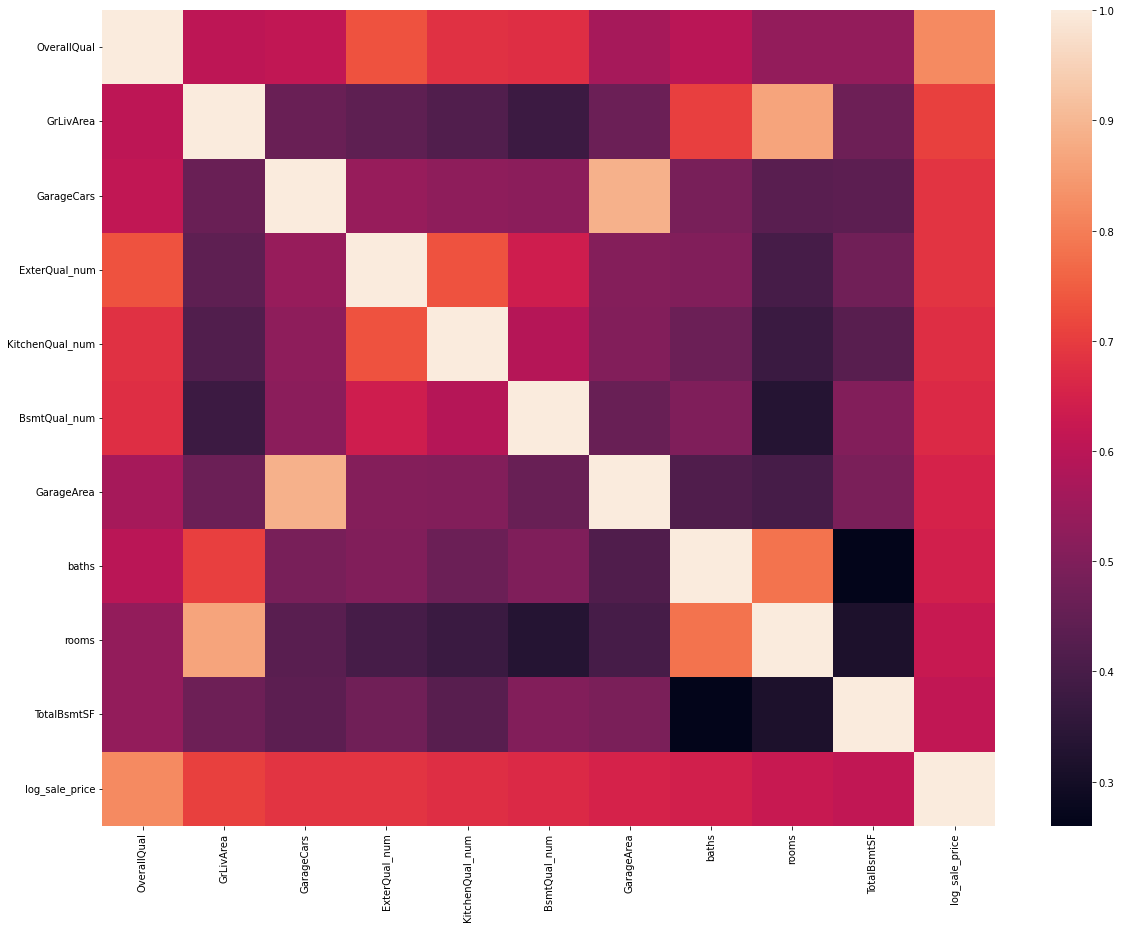

In [16]:
check_correlation(df_train, pipeline, y_col)

* rooms correlated with GrLivArea
* GarageArea correlated with GarageCars
* rooms correlated with baths
* baths partly correlated with GrLivArea

 **Conclusion:** drop rooms and GarageArea, keep baths

In [17]:
class CorrelatedColumDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, df):
        return self
    def transform(self, df):
        return df.drop(columns=self.cols)
correlated_cols = ["rooms", "GarageArea"]
get_top_corr_cols(
    Pipeline({
        **pipeline,
        "correlated_col_dropper": CorrelatedColumDropper(cols=correlated_cols),
    }.items()).fit_transform(df_train),
    y_col
)

OverallQual        0.819548
GrLivArea          0.705782
GarageCars         0.686786
ExterQual_num      0.685272
KitchenQual_num    0.673429
BsmtQual_num       0.665278
baths              0.642648
TotalBsmtSF        0.609926
1stFlrSF           0.603742
YearBuilt          0.584580
Name: log_sale_price, dtype: float64

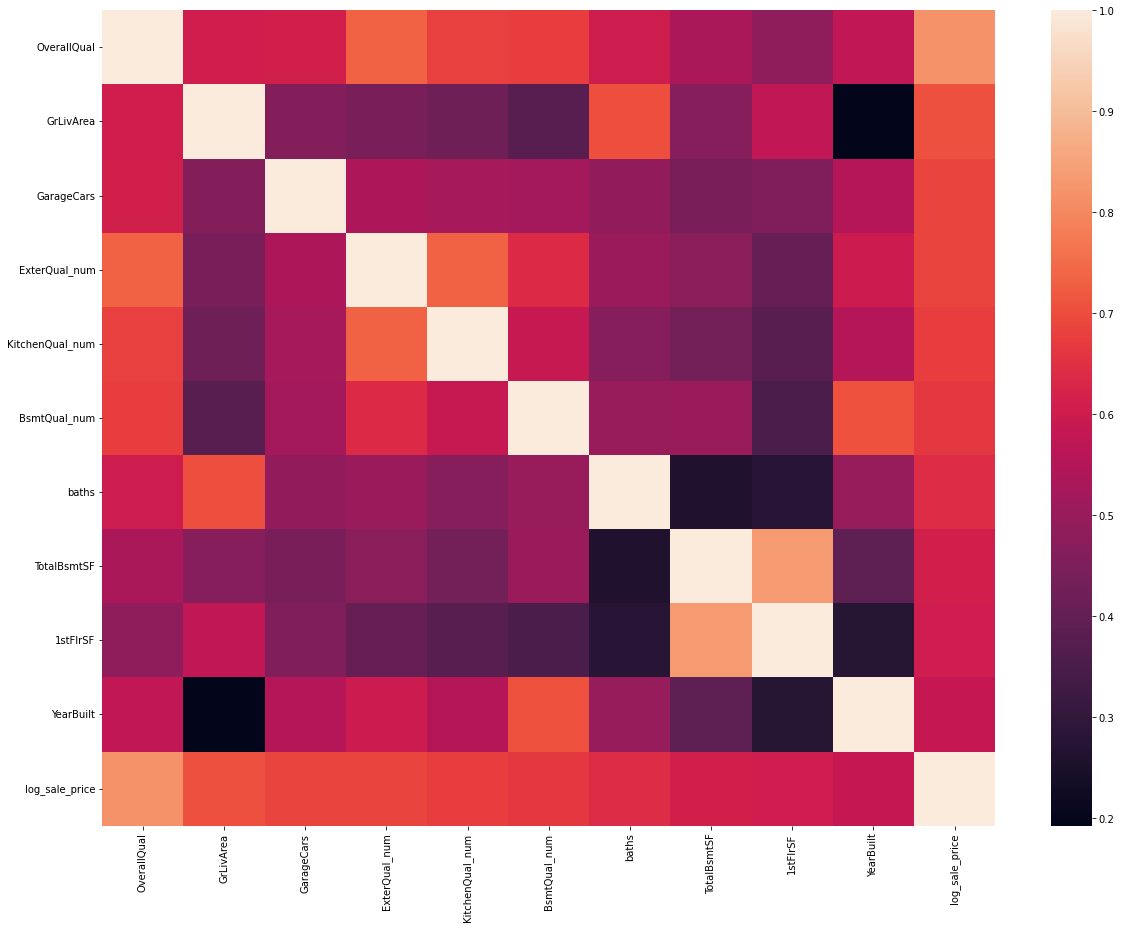

In [18]:
check_correlation(df_train,
                  {**pipeline, "correlated_col_dropper": CorrelatedColumDropper(cols=correlated_cols)},
                  y_col)

In [19]:
pipeline["correlated_col_dropper"] = CorrelatedColumDropper(cols=correlated_cols)

In [20]:
# ext_qual_num correlated with OverallQual, let's add them
sel_quality_cols = ["OverallQual", "ExterQual_num", "KitchenQual_num", "BsmtQual_num", "FireplaceQu_num"]
class QualityAdder(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=True):
        # to check improvement
        self.drop_cols = drop_cols
    def fit(self, df):
        return self
    def transform(self, df):
        df_out = df.copy()
        df_out["quality"] = df_out[sel_quality_cols].sum(axis=1)
        if self.drop_cols:
            df_out.drop(columns=sel_quality_cols, inplace=True)
        return df_out
get_top_corr_cols(
    Pipeline({
        **pipeline,
        "quality_adder": QualityAdder(drop_cols=False),
    }.items()).fit_transform(df_train),
    y_col
)

quality            0.831545
OverallQual        0.819548
GrLivArea          0.705782
GarageCars         0.686786
ExterQual_num      0.685272
KitchenQual_num    0.673429
BsmtQual_num       0.665278
baths              0.642648
TotalBsmtSF        0.609926
1stFlrSF           0.603742
Name: log_sale_price, dtype: float64

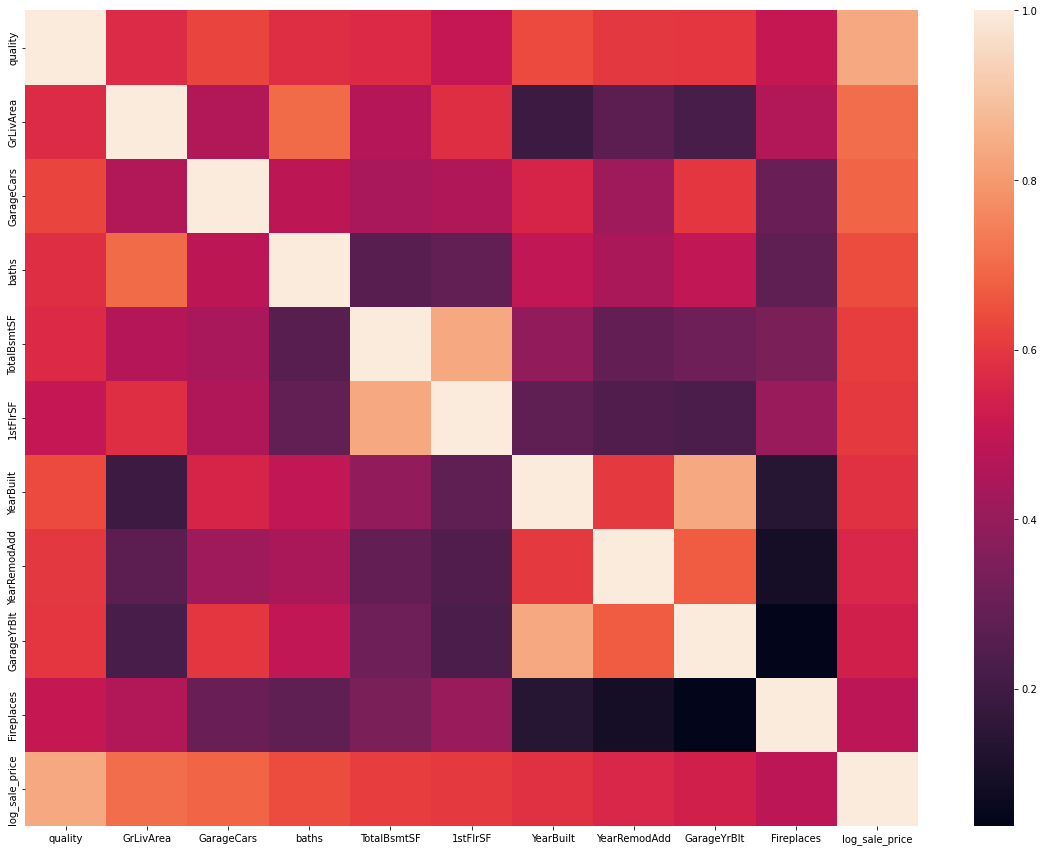

In [21]:
# quality improved correlation, drop the others
pipeline["quality_adder"] = QualityAdder()
check_correlation(df_train, pipeline, y_col)

In [22]:
# 1stFlrSF and TotalBsmtSF correlated, check if adding improve correlation with SalePrice
class SFAdderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=True):
        # to check correlation improvement
        self.drop_cols = drop_cols
    def fit(self, df):
        return self
    def transform(self, df):
        df_out = df.copy()
        df_out["1stFlrSF"].fillna(0, inplace=True)
        df_out["TotalBsmtSF"].fillna(0, inplace=True)
        df_out["total_sf"] = df_out["1stFlrSF"] + df_out["TotalBsmtSF"]
        if self.drop_cols:
            df_out.drop(columns=["1stFlrSF", "TotalBsmtSF"], inplace=True)
        return df_out
get_top_corr_cols(
    Pipeline({
        **pipeline,
        "sf_adder_transformer": SFAdderTransformer(drop_cols=False),
    }.items()).fit_transform(df_train),
    y_col
)

quality         0.831545
GrLivArea       0.705782
GarageCars      0.686786
baths           0.642648
total_sf        0.633562
TotalBsmtSF     0.609926
1stFlrSF        0.603742
YearBuilt       0.584580
YearRemodAdd    0.558338
GarageYrBlt     0.535133
Name: log_sale_price, dtype: float64

In [23]:
# total_sf gets better correlation, drop others
pipeline["sf_adder_transformer"] = SFAdderTransformer()

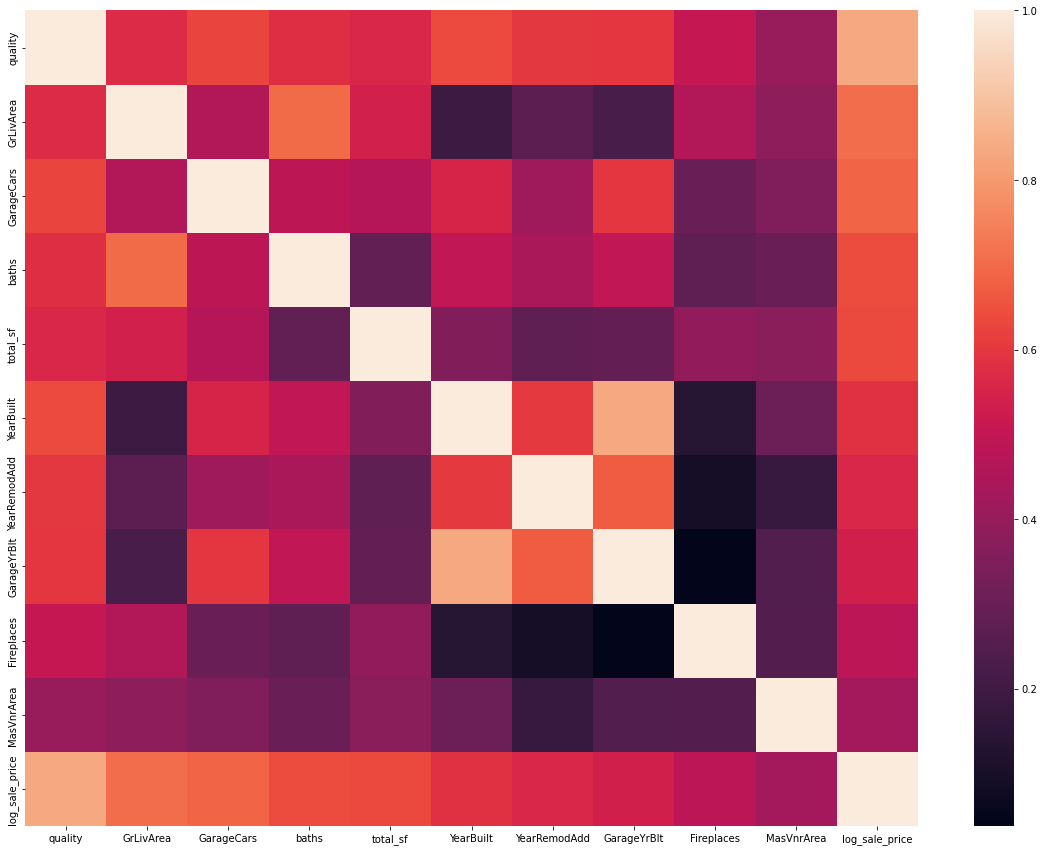

In [24]:
check_correlation(df_train, pipeline, y_col)

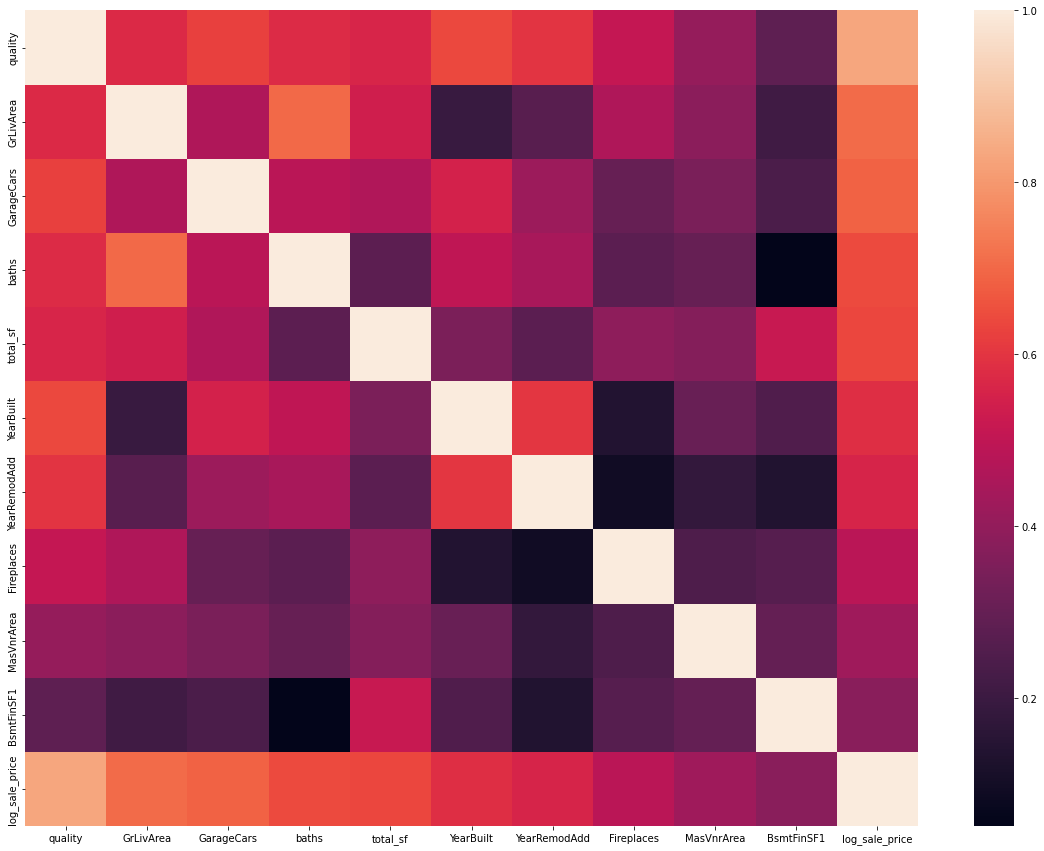

In [25]:
# GarageYrBlt correlated with YearBuilt, drop it
correlated_cols.append("GarageYrBlt")
pipeline["correlated_col_dropper"] = CorrelatedColumDropper(cols=correlated_cols)
check_correlation(df_train, pipeline, y_col)

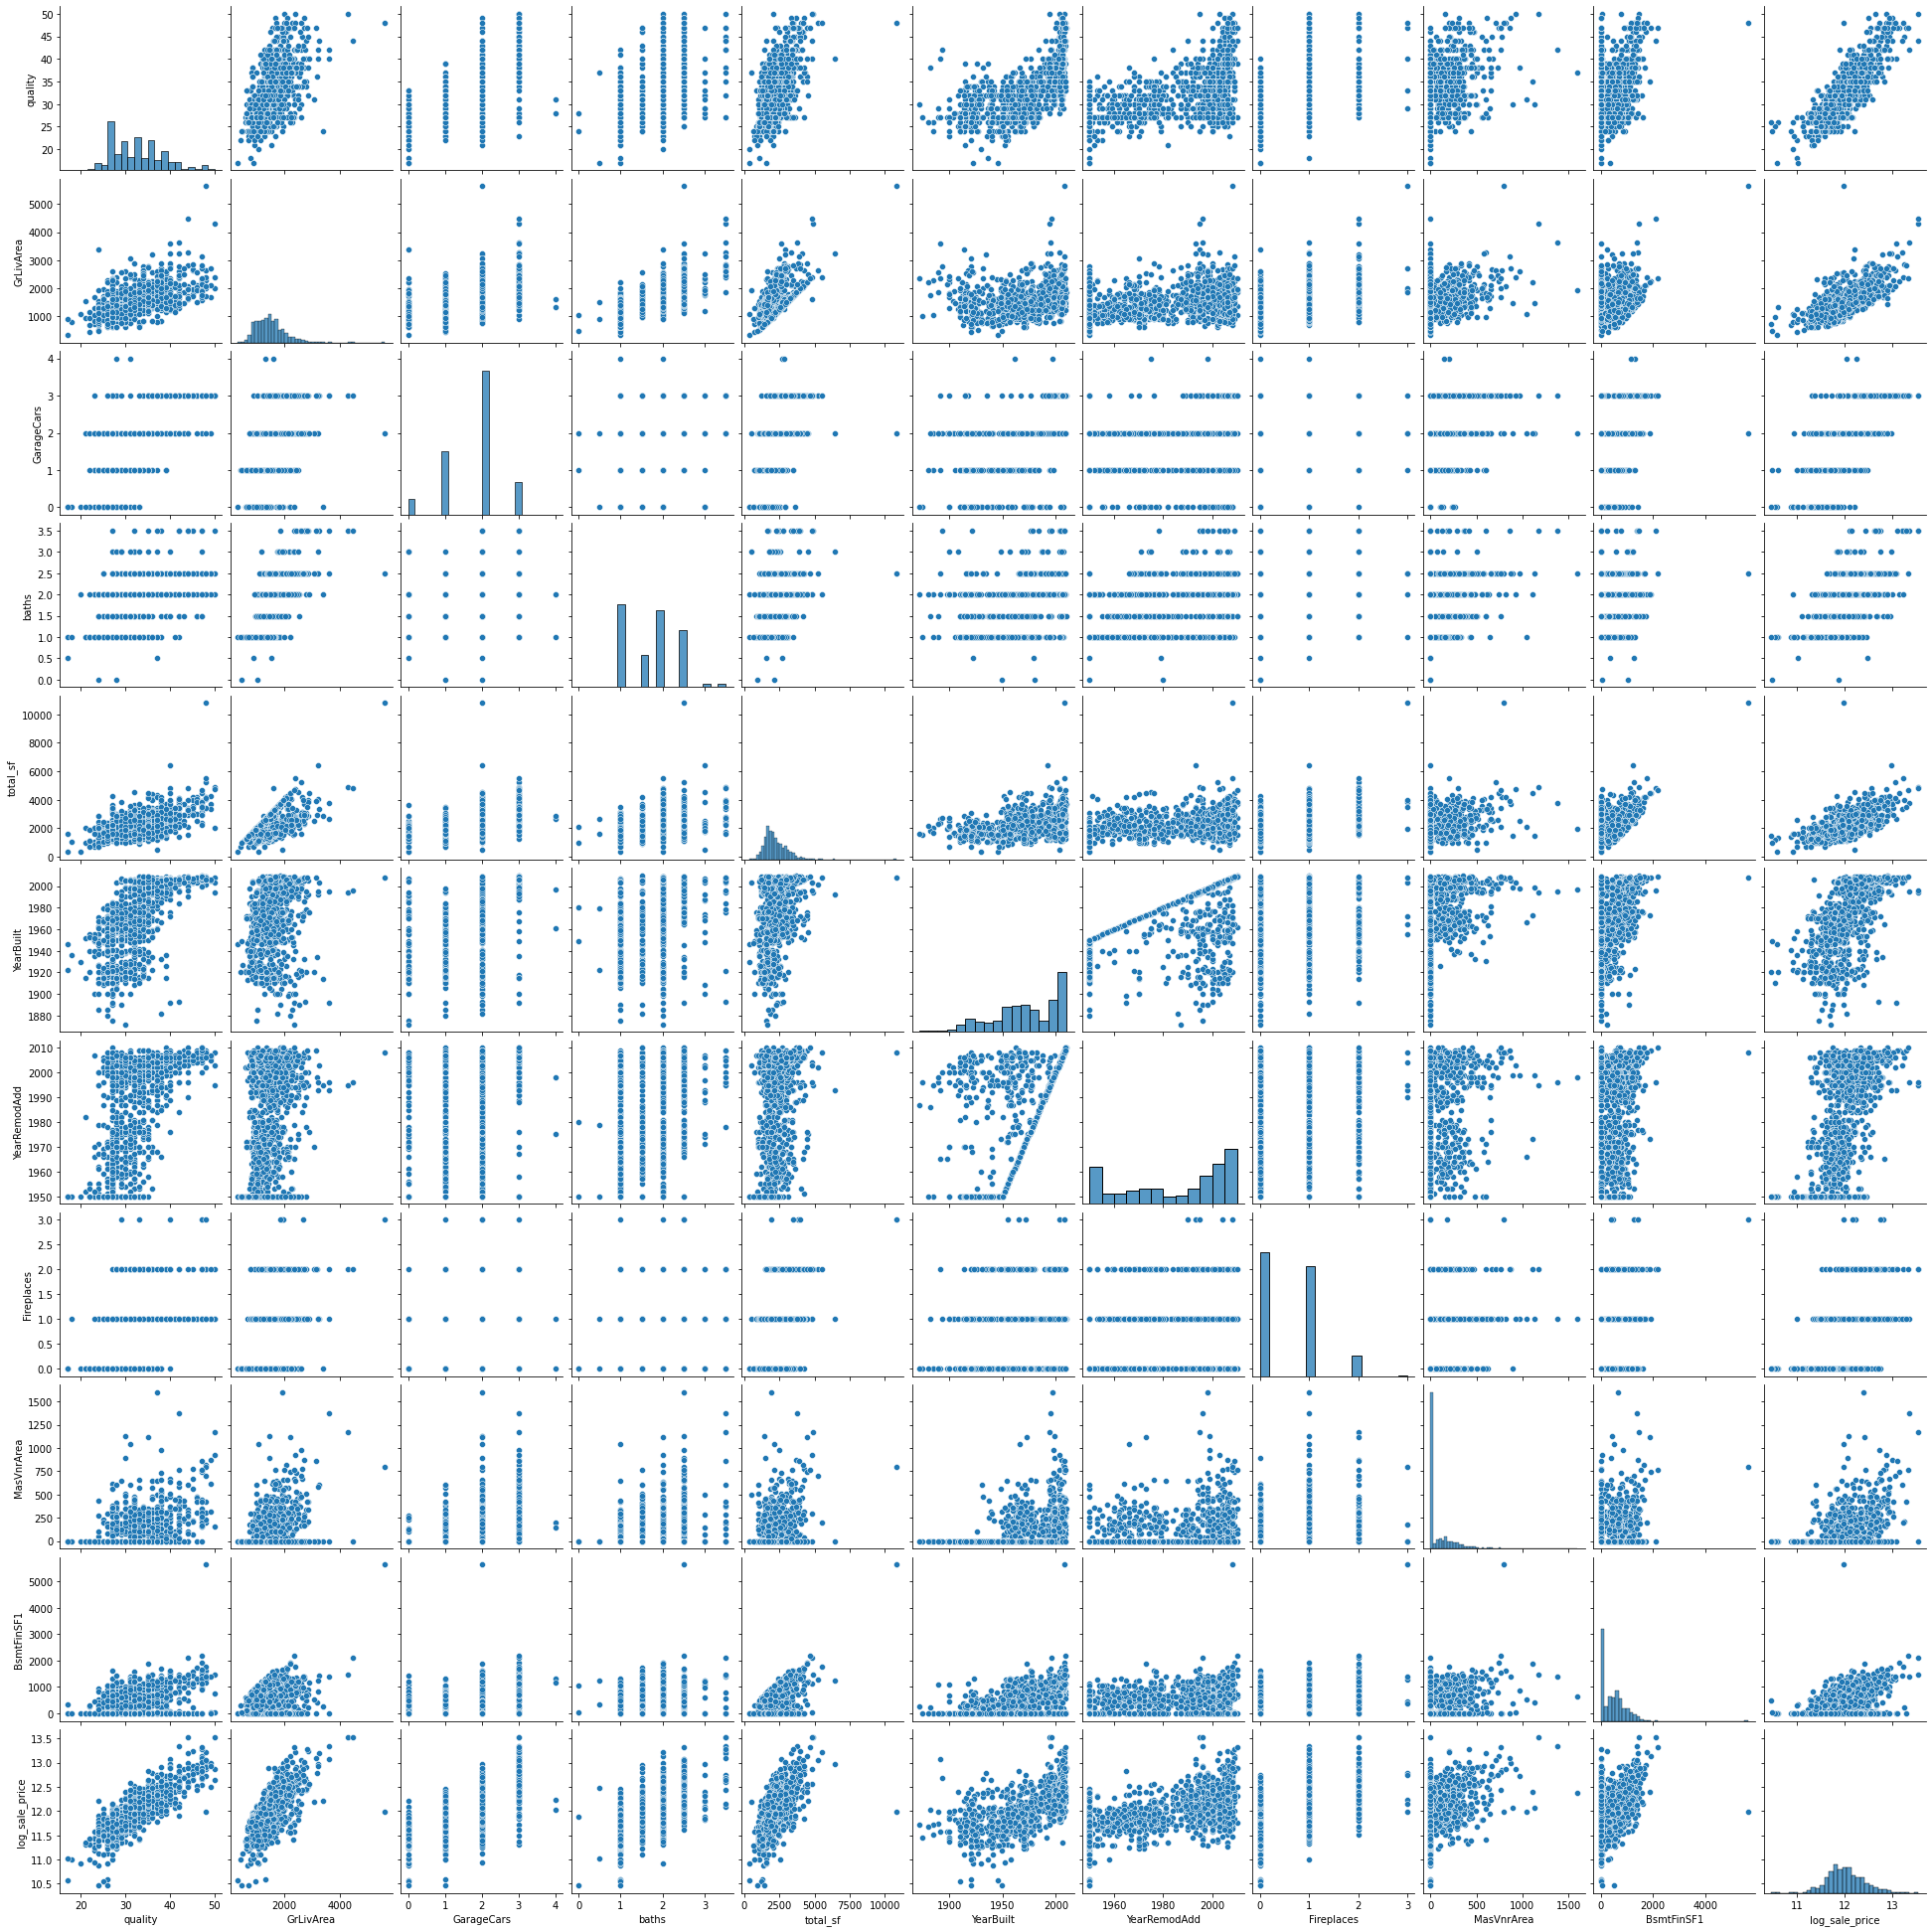

In [26]:
def pairplot_top_correlated(df_train, pipeline, y_col):
    df_treat = Pipeline(pipeline.items()).fit_transform(df_train)
    interest_cols = list(get_top_corr_cols(df_treat, y_col).index)
    sns.pairplot(df_treat[interest_cols + [y_col]])
pairplot_top_correlated(df_train, pipeline, y_col)

**Obs:** Check MasVnrArea distribution, BasmtFnSF dist., GrLivArea-total_sf corr., total_sf-BasmTFnSF

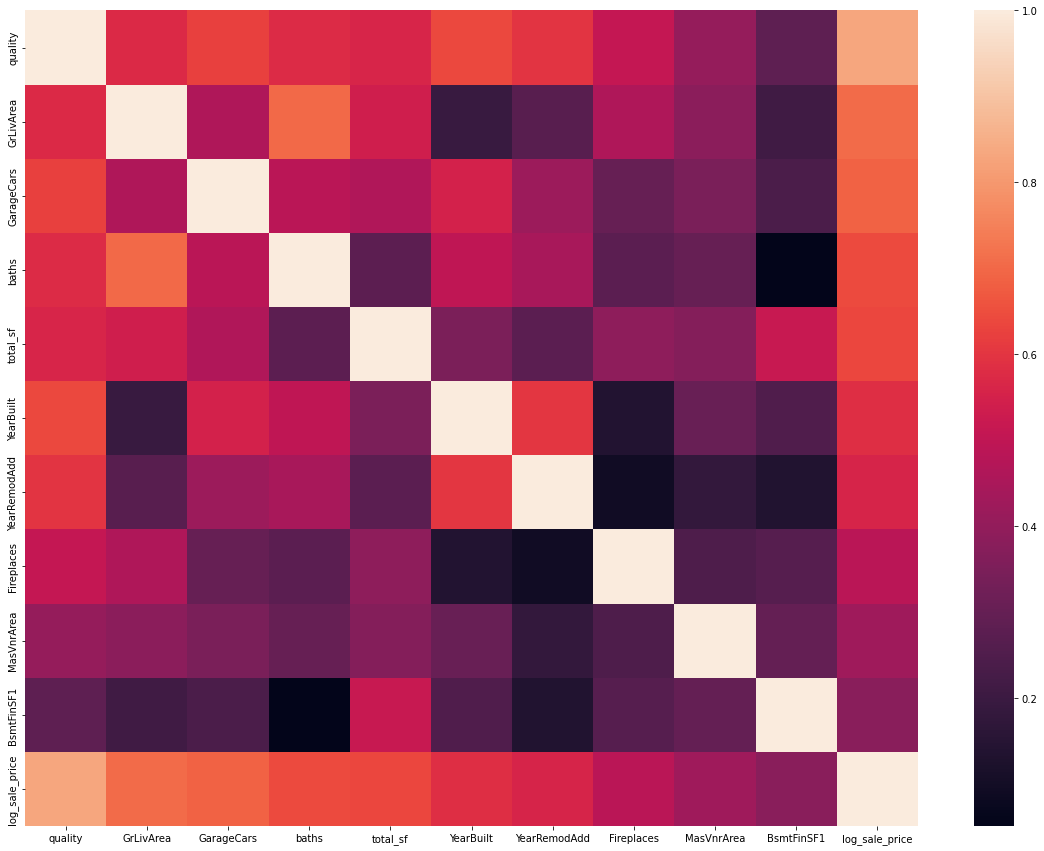

In [27]:
check_correlation(df_train, pipeline, y_col)

In [28]:
class TopCorrSelector(BaseEstimator, TransformerMixin):
    def __init__(self, y_col, n_cols=10):
        self.y_col = y_col
        self.top_cols = []
        self.n_cols = n_cols
    def fit(self, df):
        self.top_cols = list(get_top_corr_cols(df, y_col).index)[:self.n_cols]
        self.top_cols = list(filter(lambda col: col != y_col, self.top_cols))
        return self
    def transform(self, df):
        return df[self.top_cols].fillna(0)

In [29]:
pipeline["top_corr_selector"] = TopCorrSelector(y_col)

In [30]:
num_pipeline_dict = pipeline.copy()

num_pipeline["standard_scaler"] = StandardScaler()

**Obs** Standardize worst output

del num_pipeline["standard_scaler"]

# Categorical features analysis 

In [31]:
cat_pipeline_dict = {}

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 1338 to 1346
Data columns (total 82 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1168 non-null   int64  
 1   MSSubClass      1168 non-null   int64  
 2   MSZoning        1168 non-null   object 
 3   LotFrontage     963 non-null    float64
 4   LotArea         1168 non-null   int64  
 5   Street          1168 non-null   object 
 6   Alley           71 non-null     object 
 7   LotShape        1168 non-null   object 
 8   LandContour     1168 non-null   object 
 9   Utilities       1168 non-null   object 
 10  LotConfig       1168 non-null   object 
 11  LandSlope       1168 non-null   object 
 12  Neighborhood    1168 non-null   object 
 13  Condition1      1168 non-null   object 
 14  Condition2      1168 non-null   object 
 15  BldgType        1168 non-null   object 
 16  HouseStyle      1168 non-null   object 
 17  OverallQual     1168 non-null 

In [33]:
cat_drop_cols = ["Alley", "Fence", "MiscFeature"]
class CatColDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=[]):
        self.drop_cols = drop_cols
    def fit(self, df):
        return self
    def transform(self, df):
        return df.drop(columns=self.drop_cols)
cat_pipeline_dict["cat_col_dropper"] = CatColDropper(cat_drop_cols)

In [34]:
# Check if pools binary variable is correlated
class PoolsEncoder(BaseEstimator, TransformerMixin):
    def fit(self, df):
        return self
    def transform(self, df):
        df_out = df.copy()
        df_out["pools"] = "0"
        df_out["pools"] = df_out["pools"].where(df_out["PoolQC"].isna(), "1")
        return df_out.drop(columns=["PoolQC"])
cat_pipeline_dict["pool_encoder"] = PoolsEncoder()

In [35]:
def bar_plotter(df, y_col, ignore_cols=[]):
    dts = df.dtypes
    cat_cols = [col for col in dts[dts=="object"].index if col not in sel_quality_cols+quality_cols]
    for col in cat_cols:
        if col not in ignore_cols:
            _, ax = plt.subplots(figsize=(20, 10))
            sns.histplot(data=df, x=col, ax=ax)
            ax.plot()

In [36]:
def box_plotter(df, y_col, max_box=5, ignore_cols=[]):
    dts = df.dtypes
    cat_cols = [col for col in dts[dts=="object"].index if col not in sel_quality_cols+quality_cols]
    for col in cat_cols:
        if col not in ignore_cols and (max_box==-1 or len(df[col].unique()) <= max_box):
            _, ax = plt.subplots(figsize=(20, 10))
            sns.boxplot(data=df, x=col, y=y_col, ax=ax)
            ax.plot()

/tmp/ipykernel_4208/1374639643.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=(20, 10))


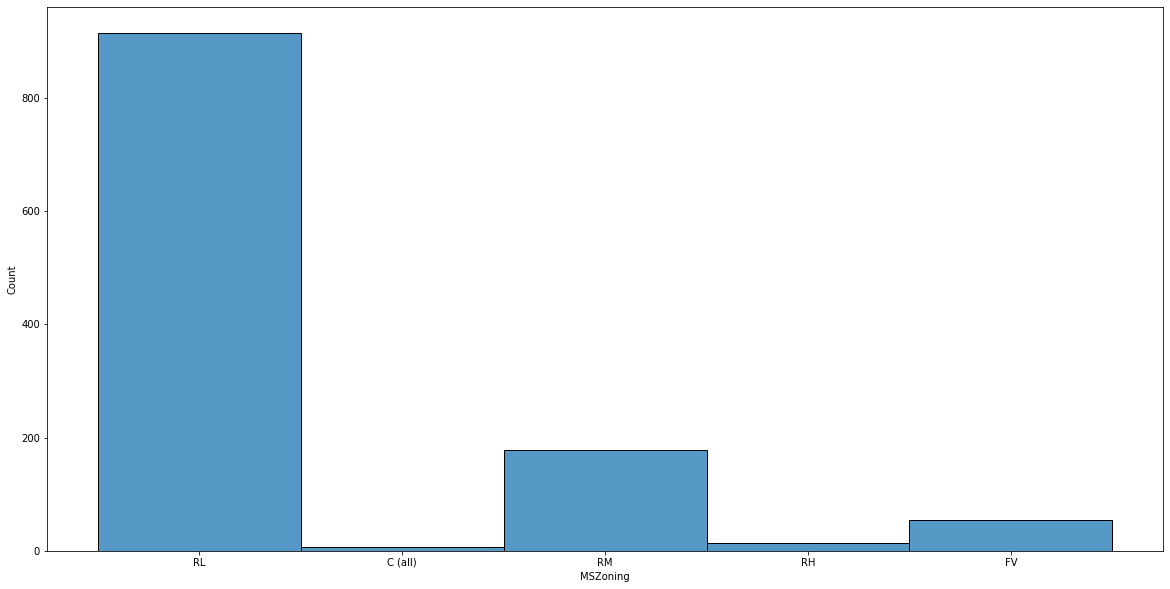

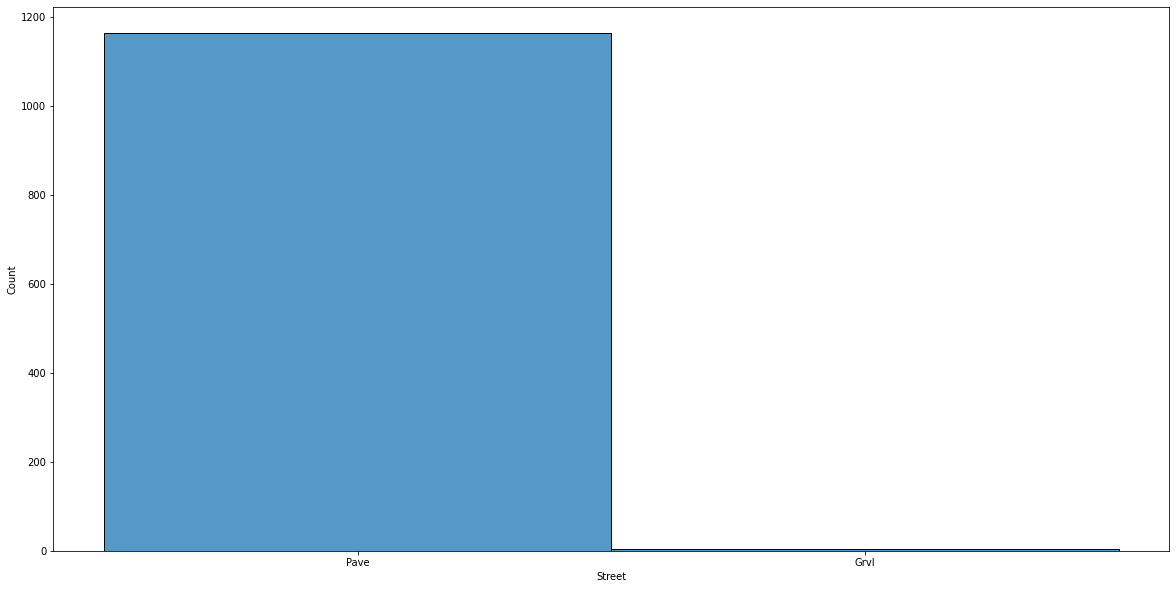

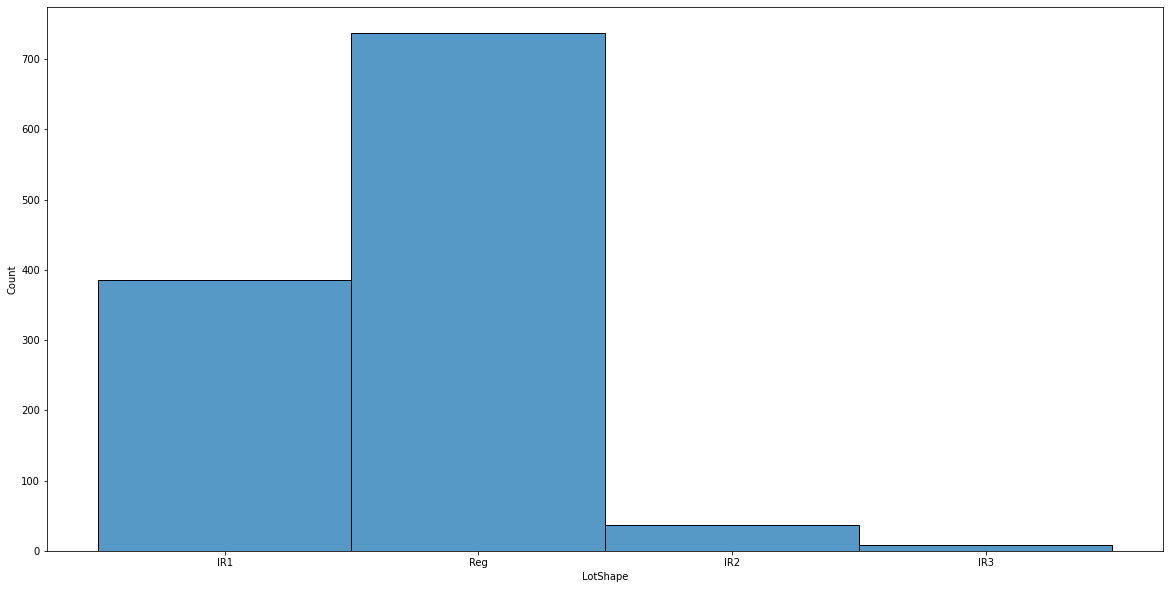

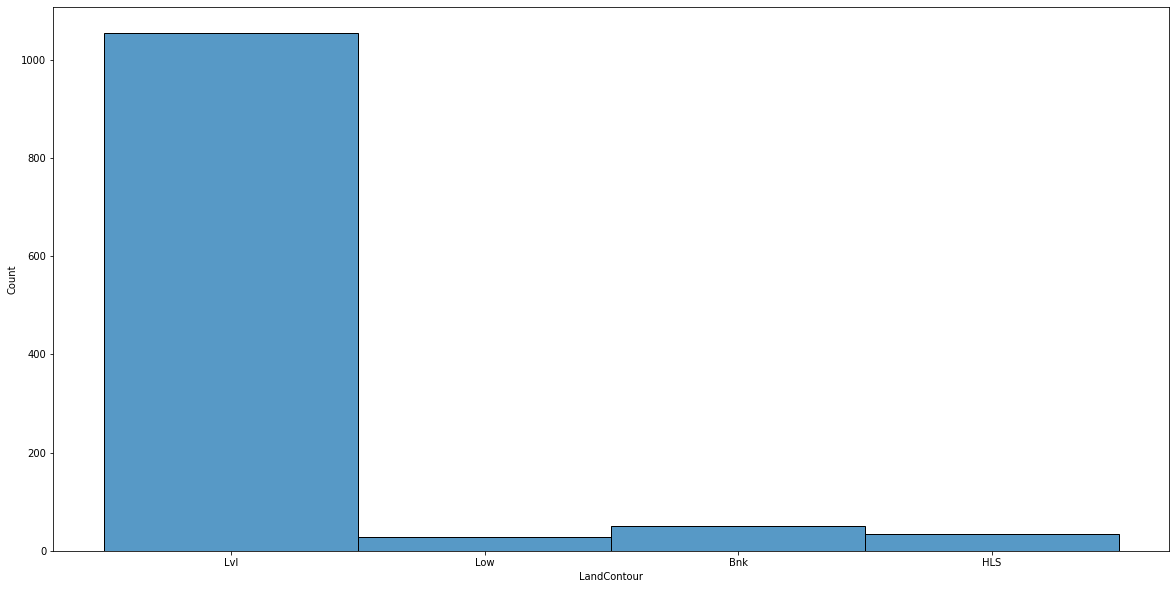

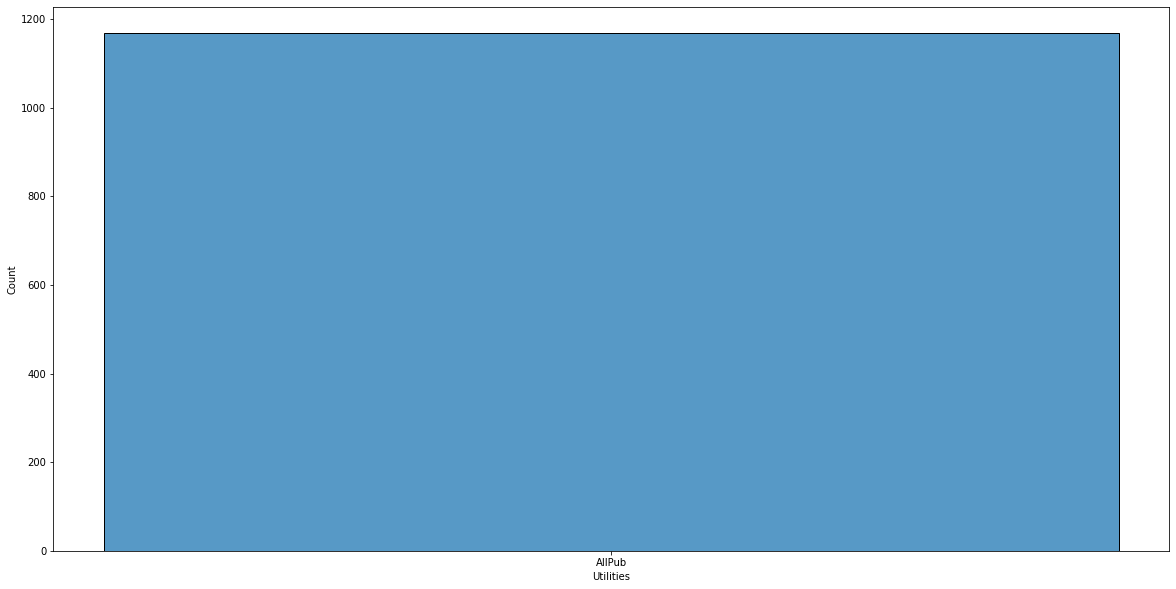

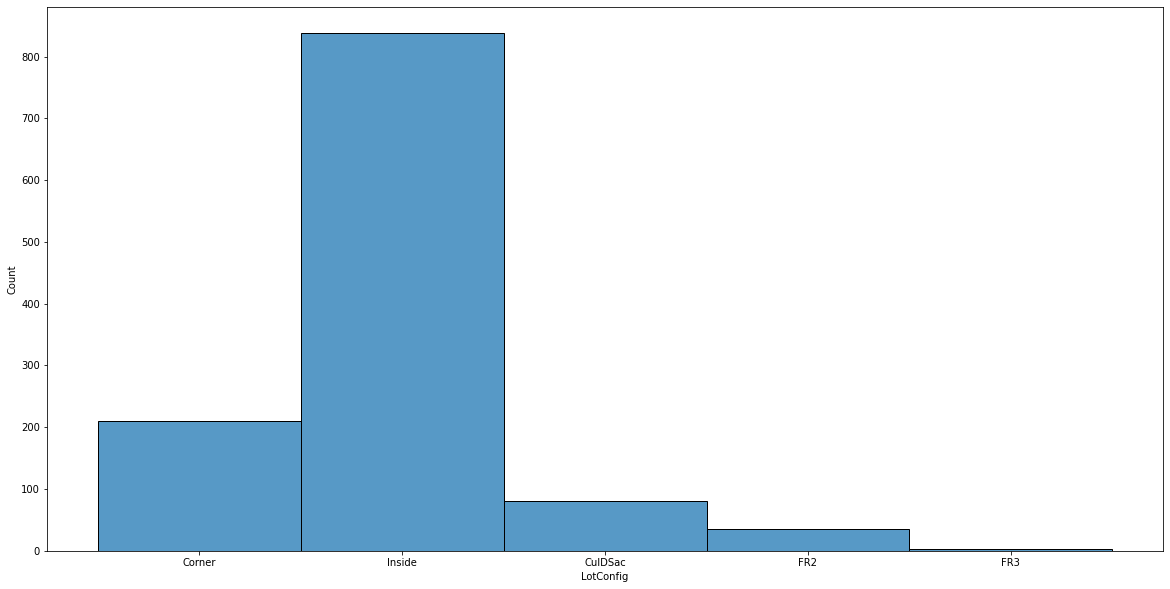

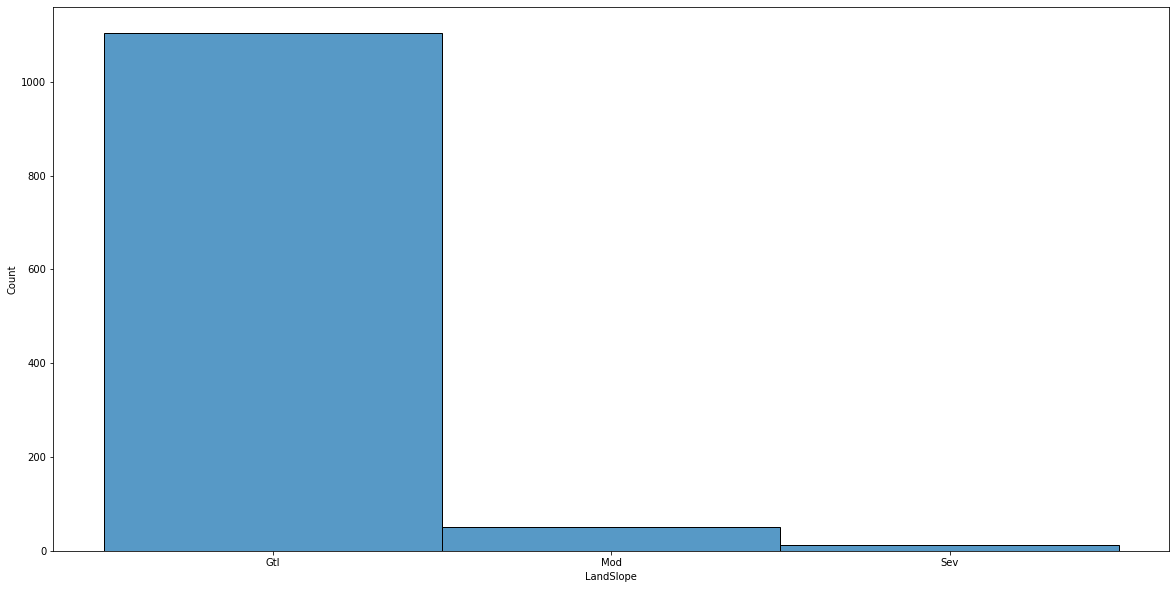

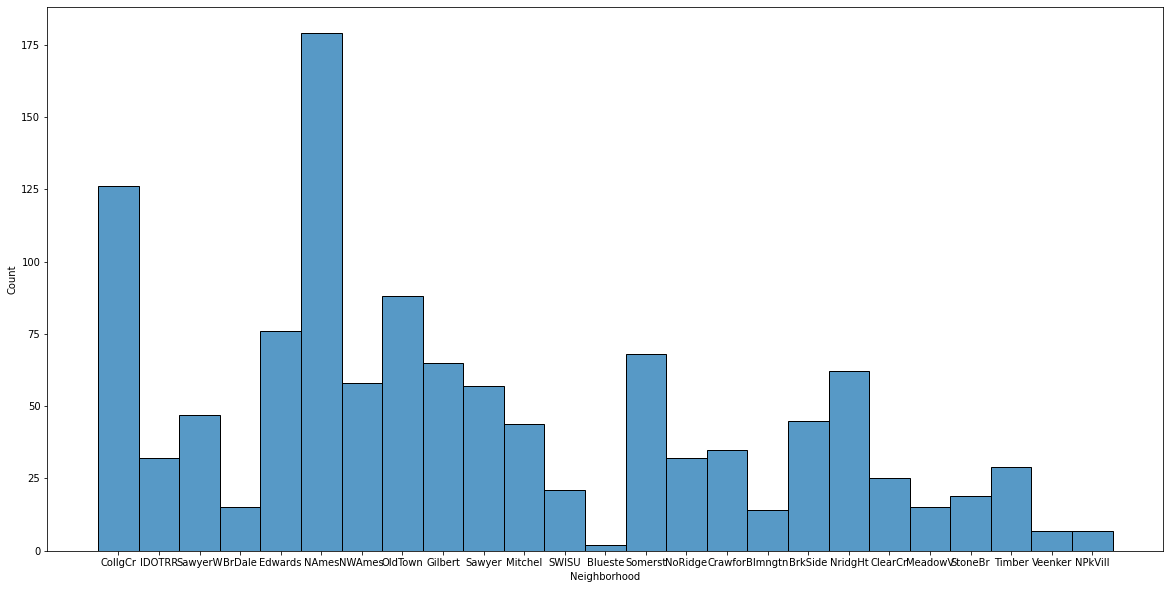

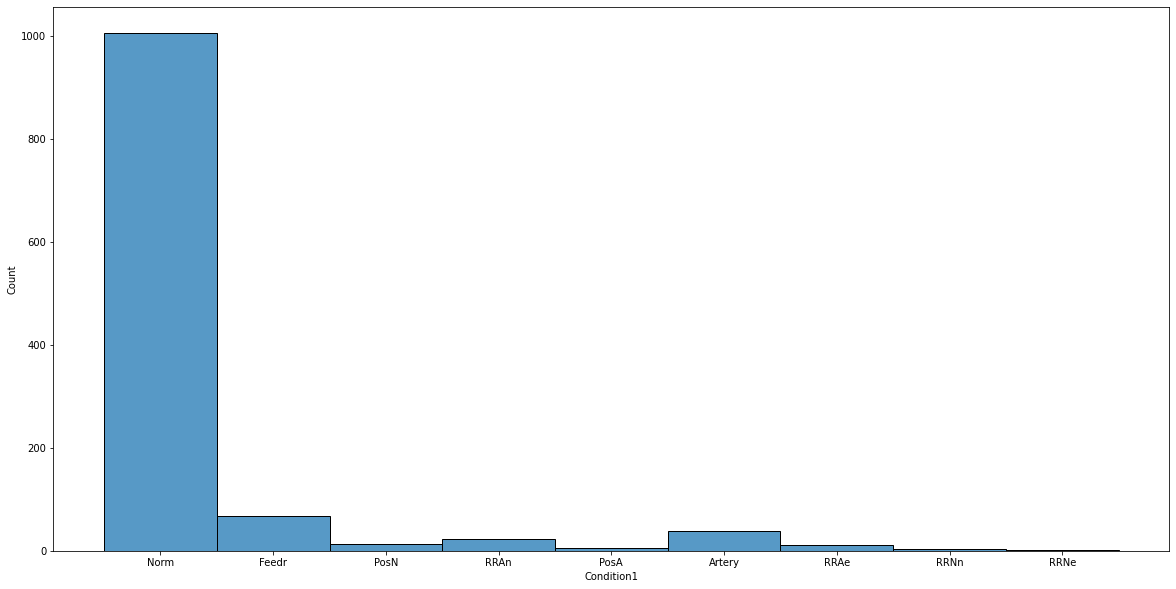

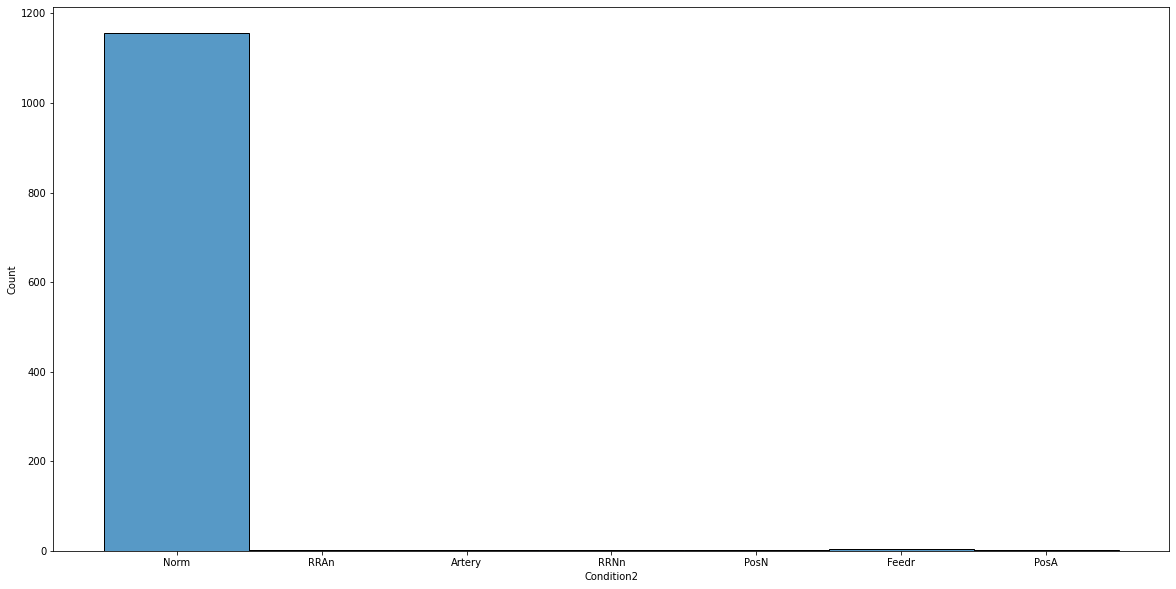

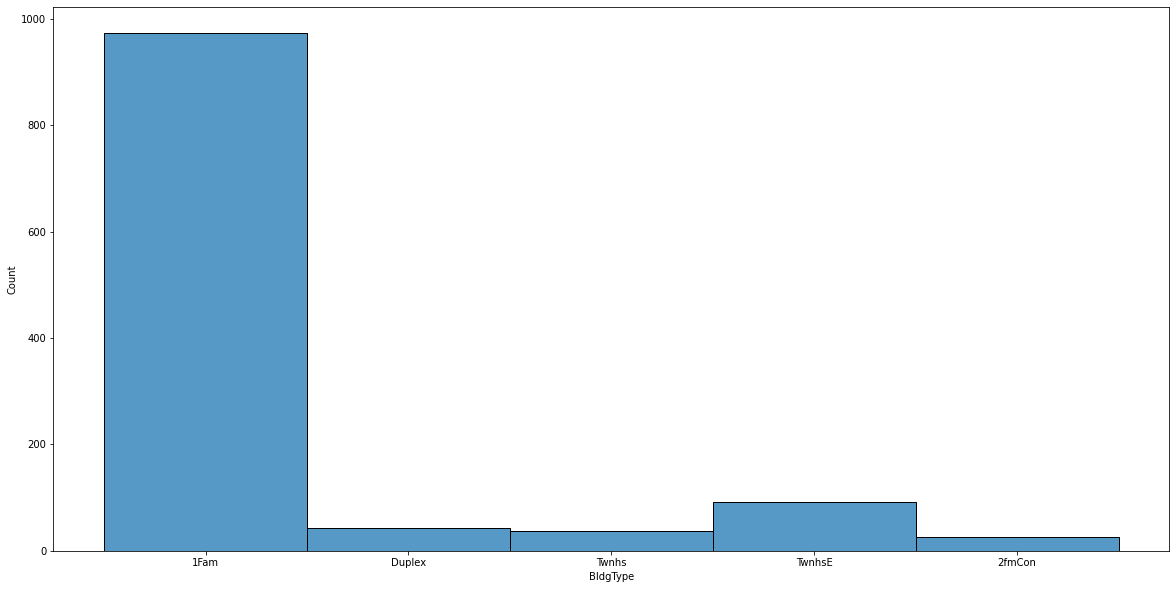

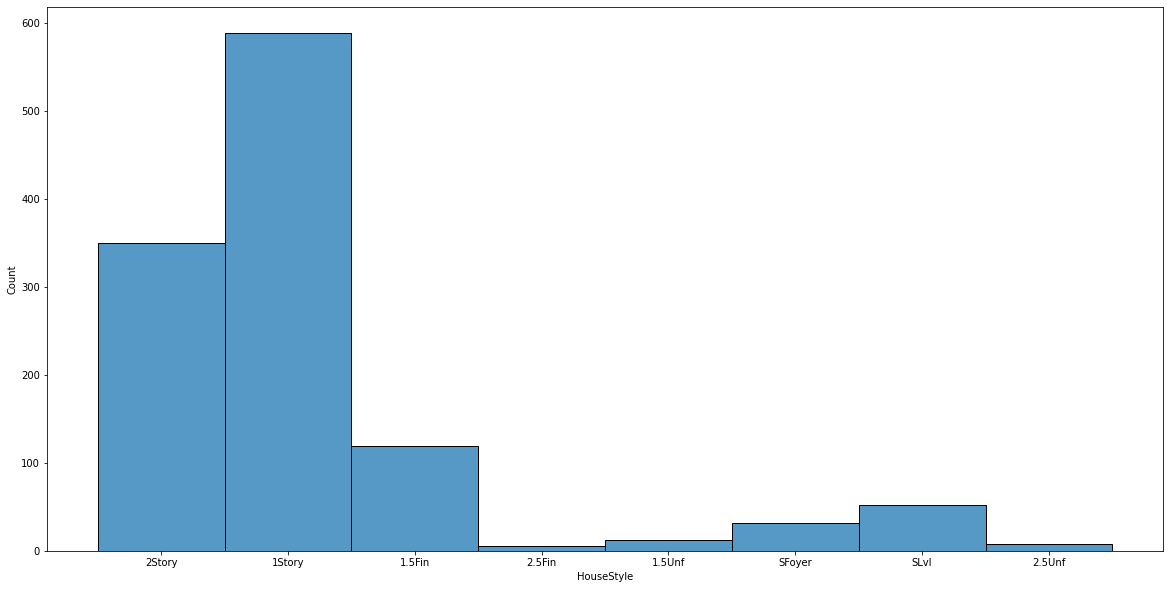

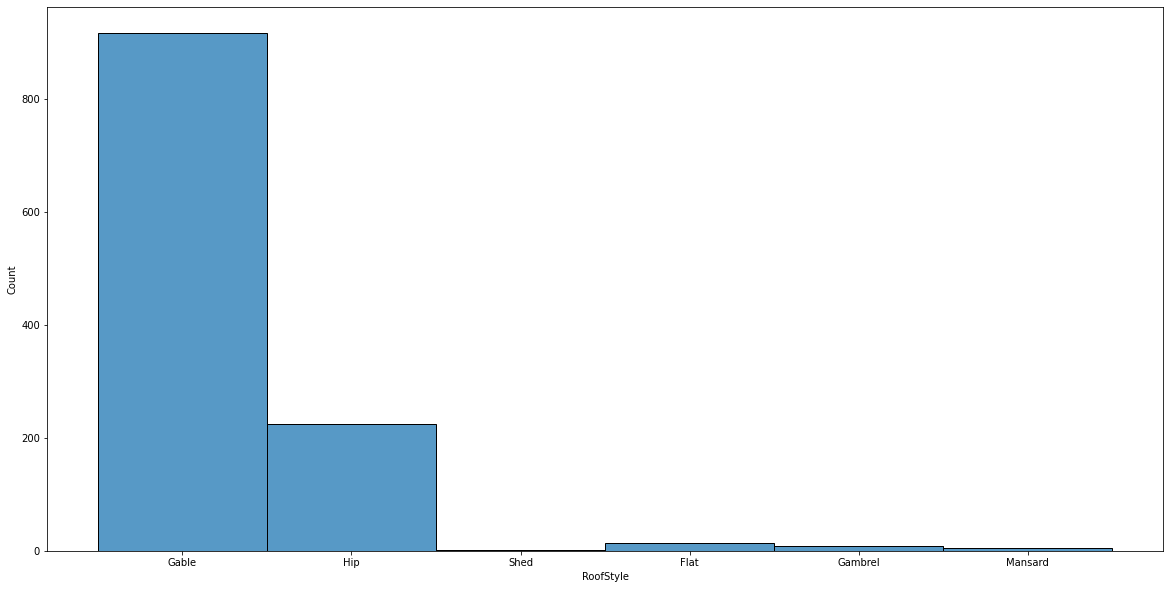

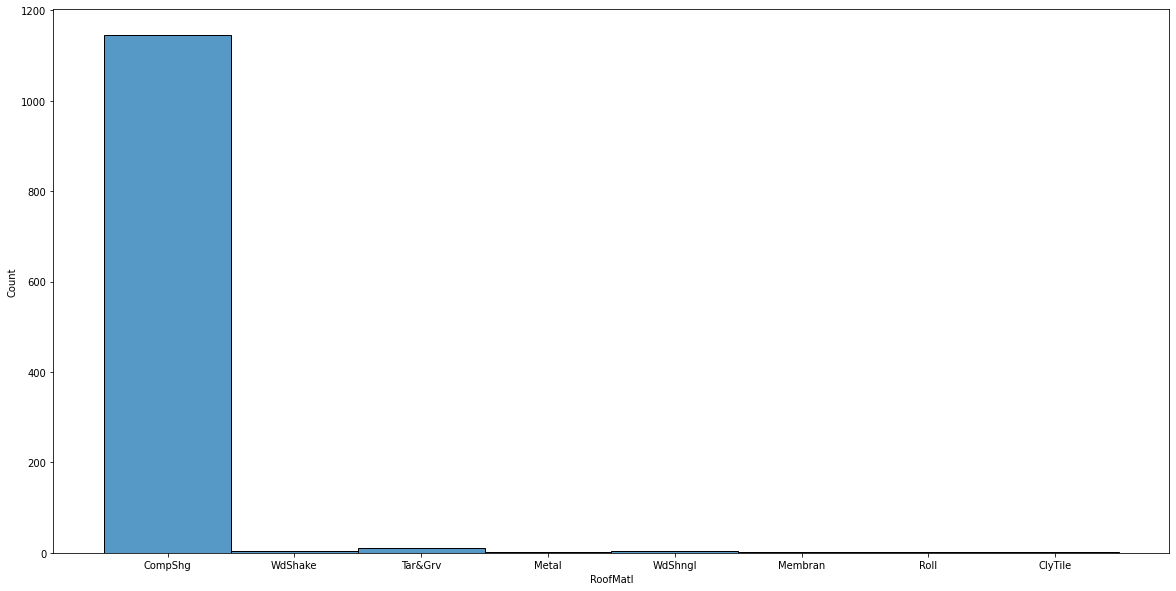

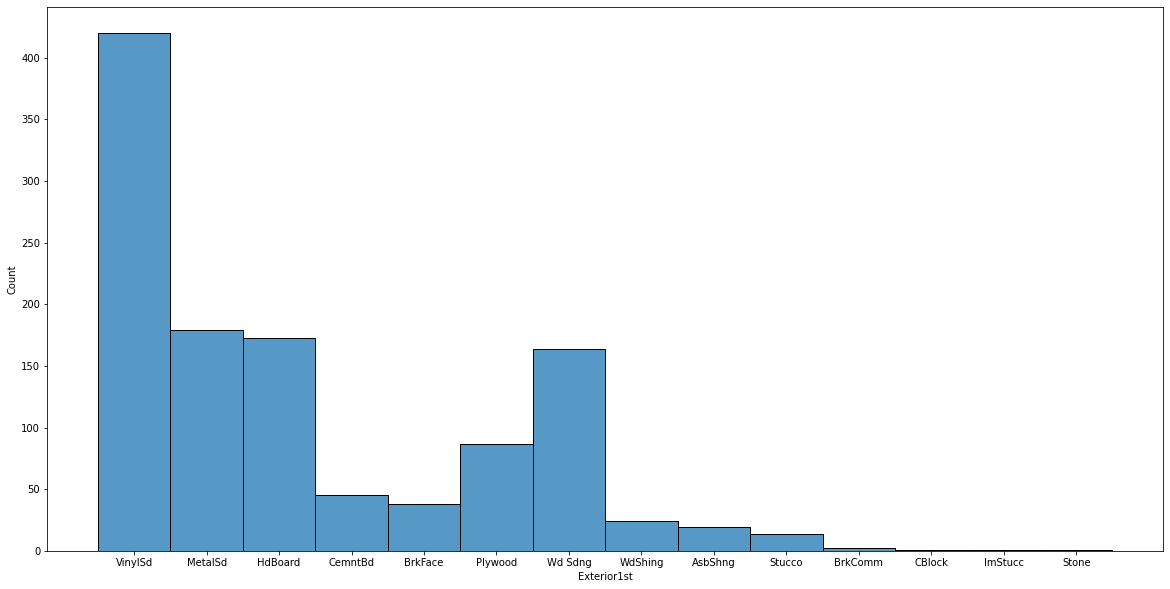

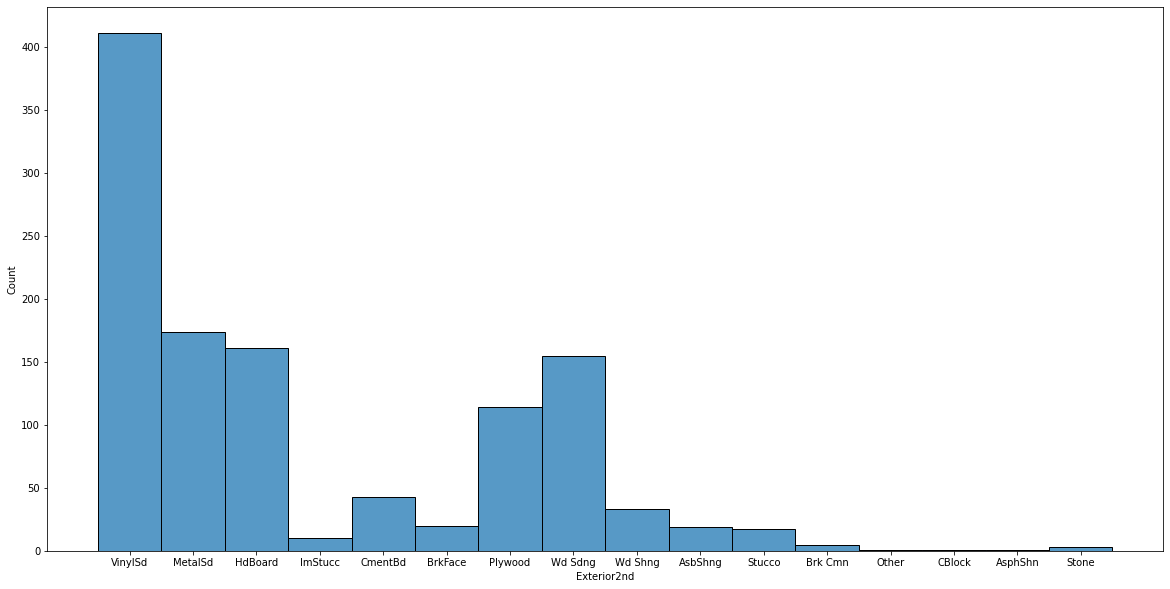

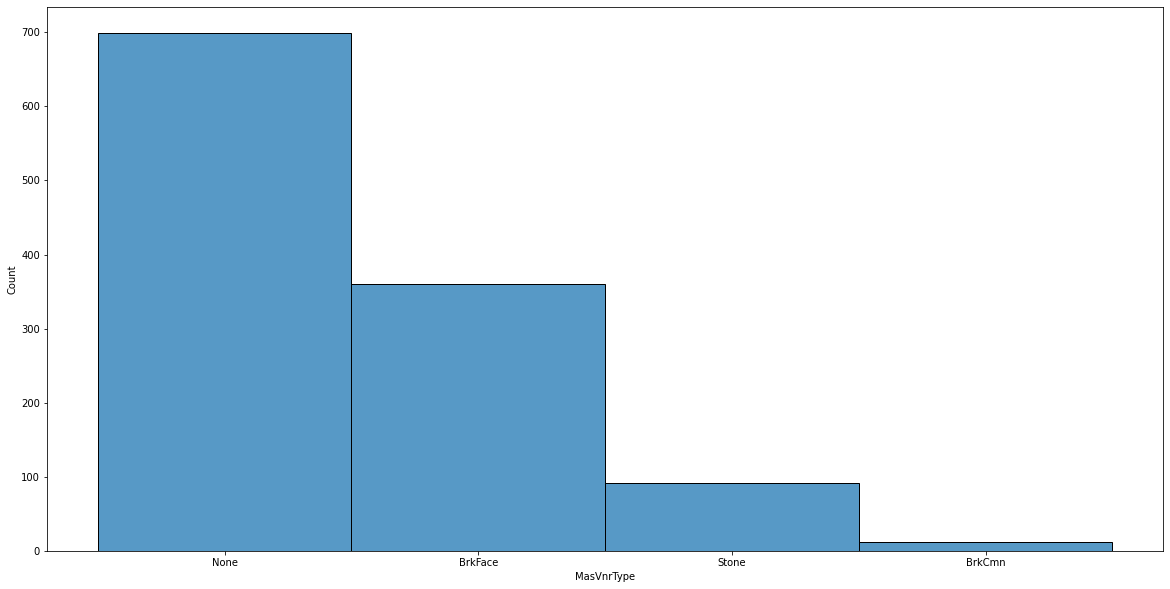

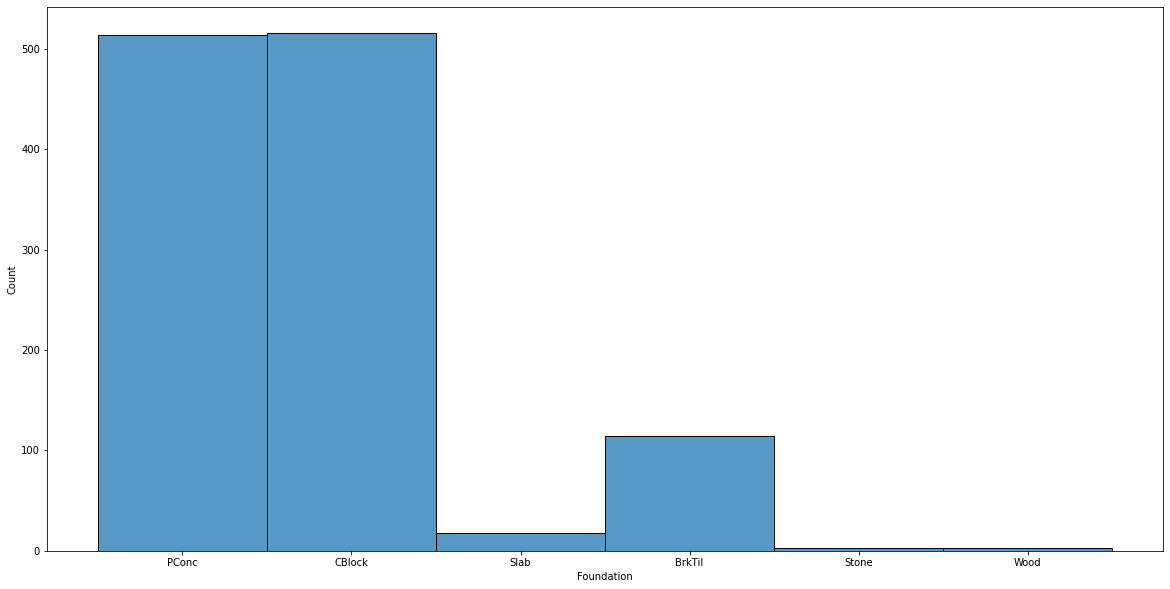

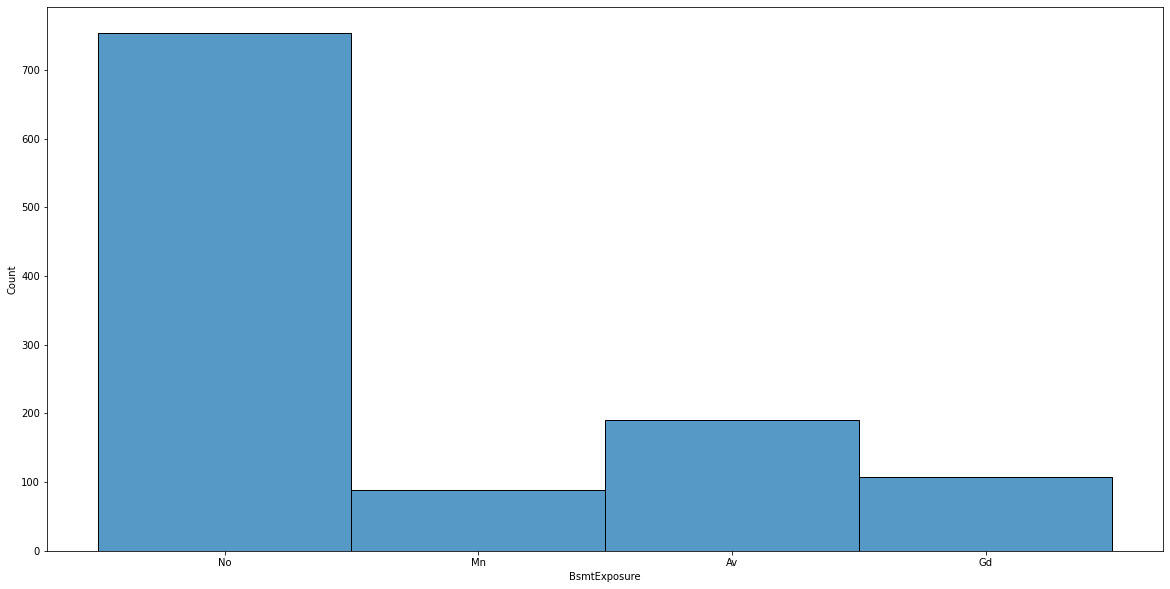

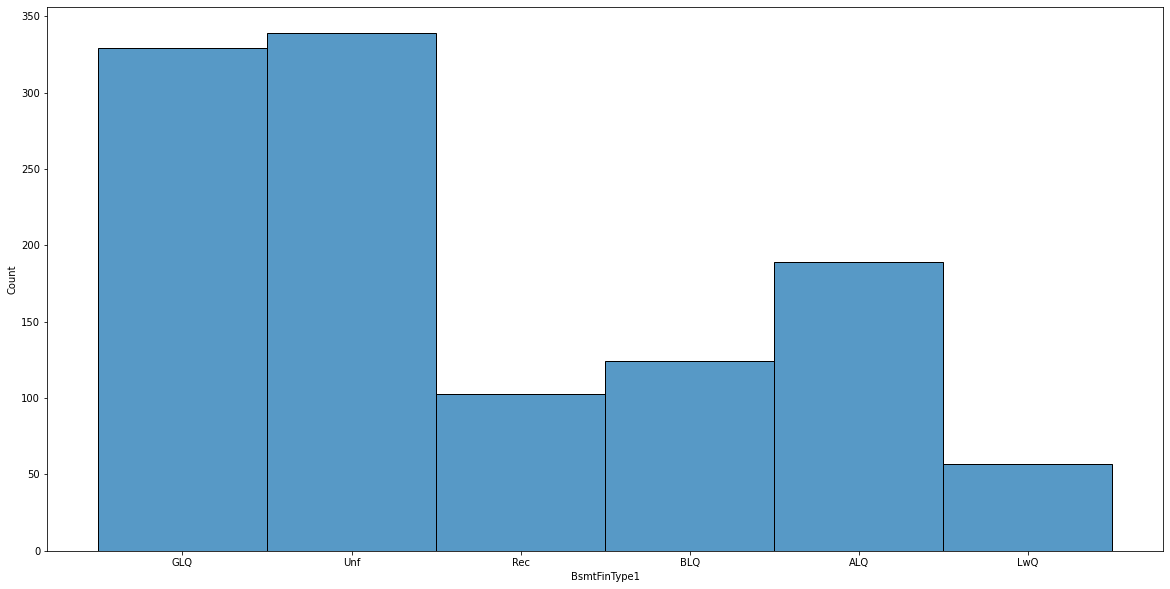

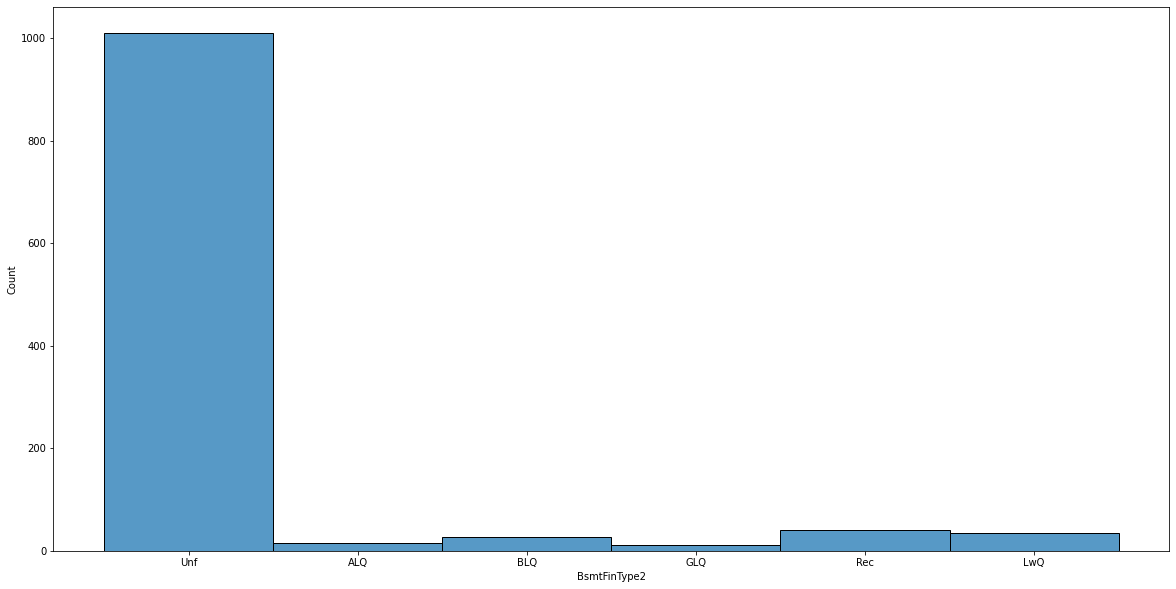

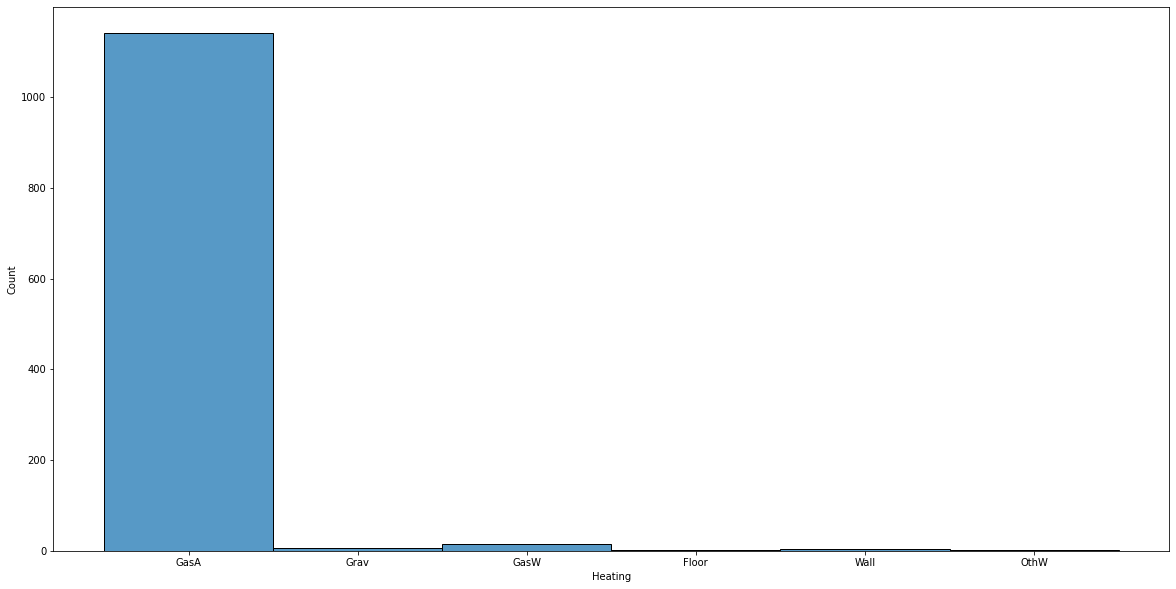

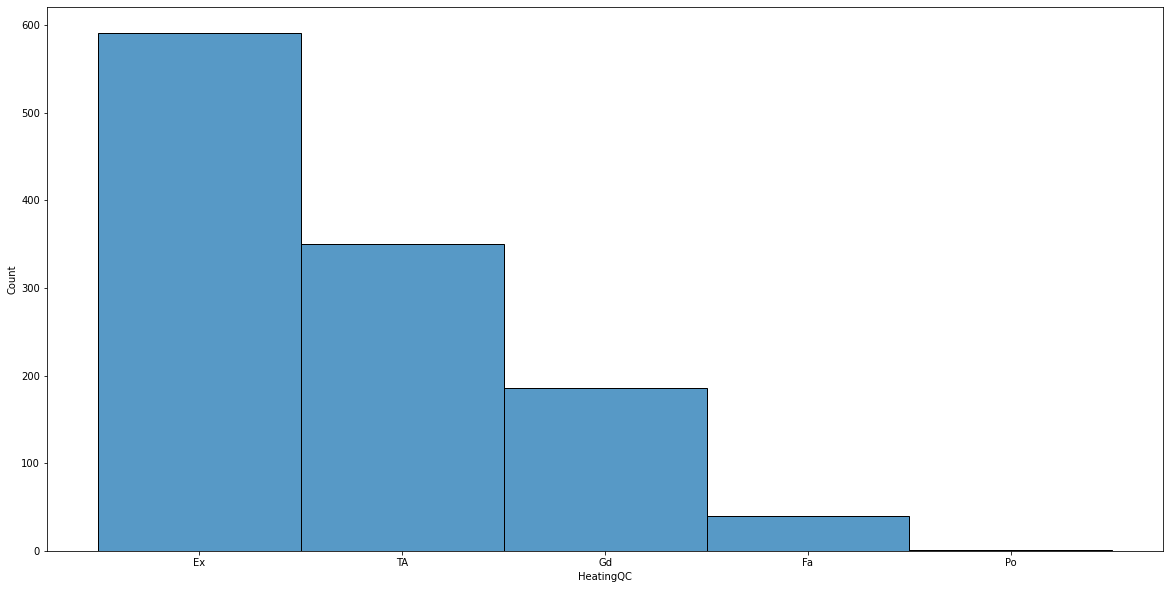

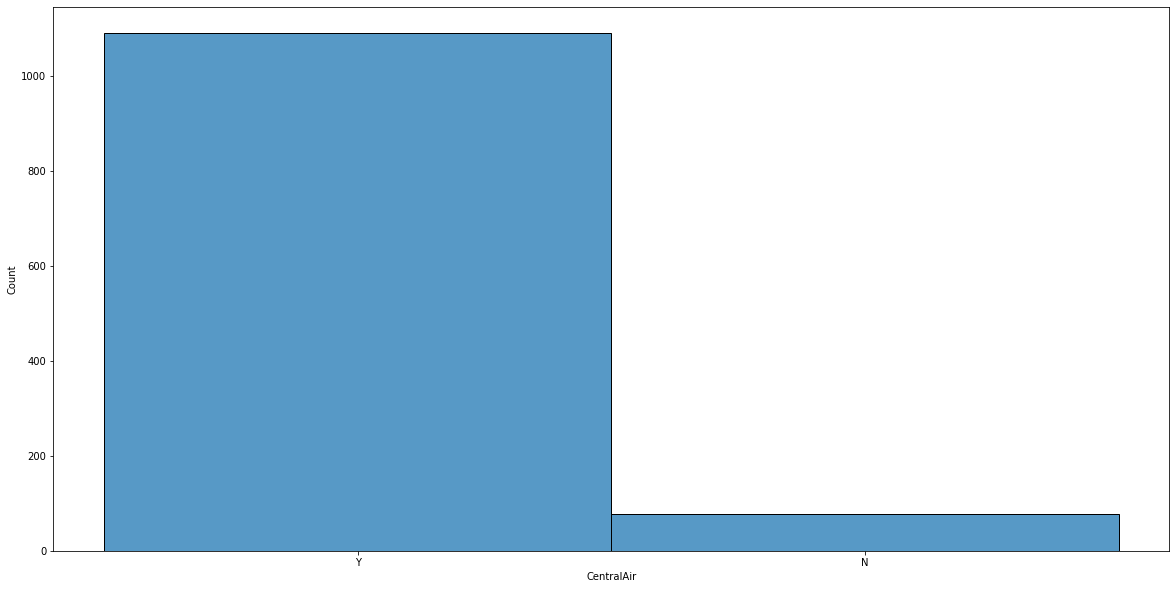

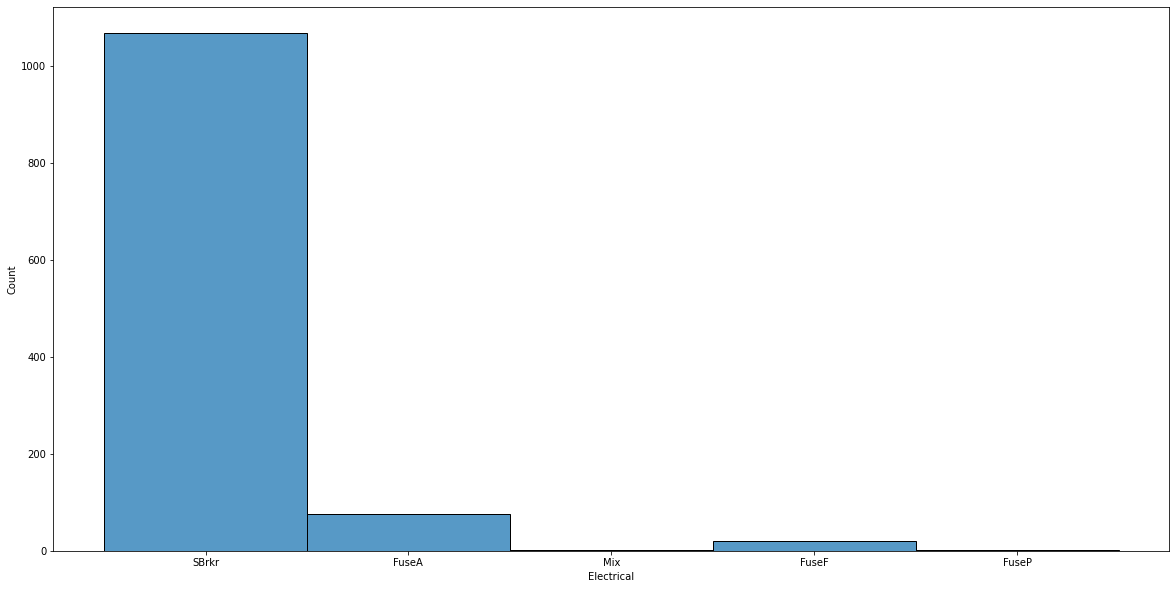

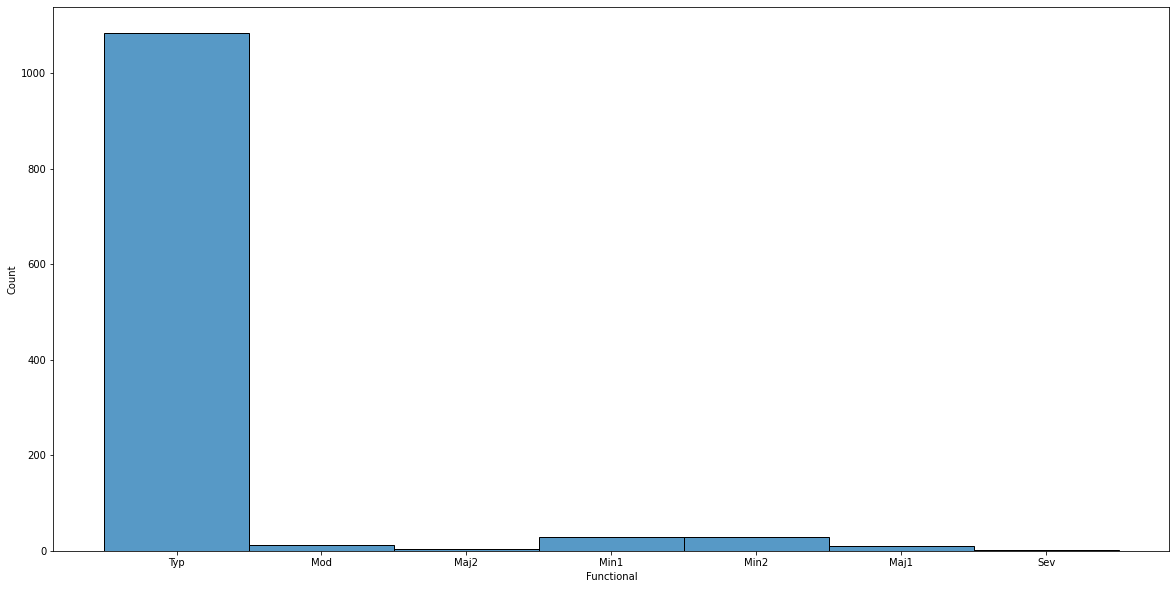

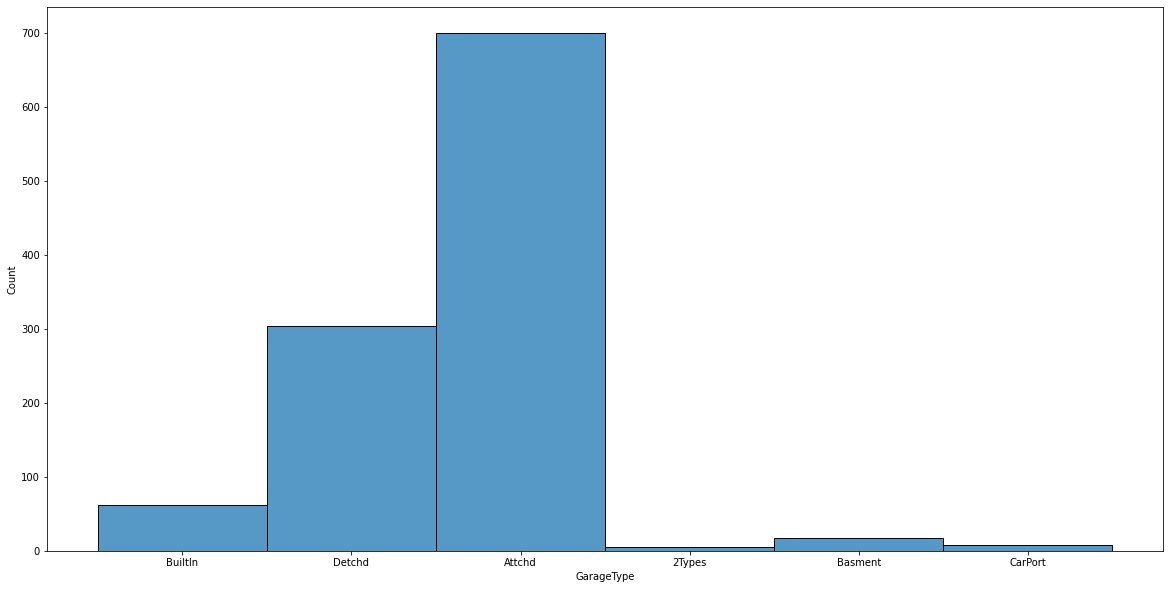

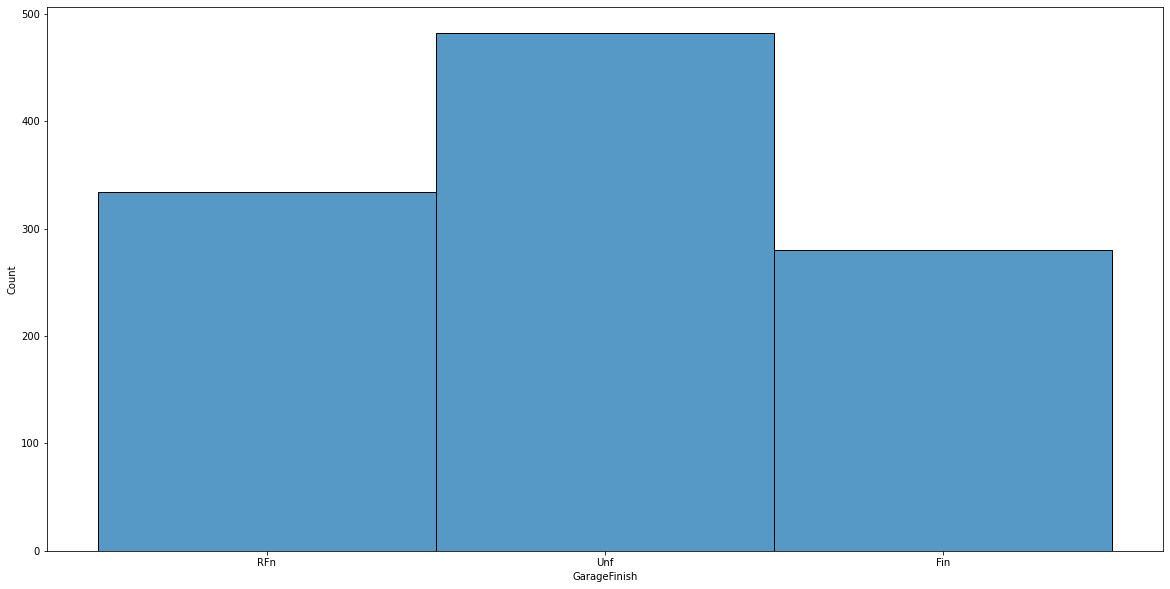

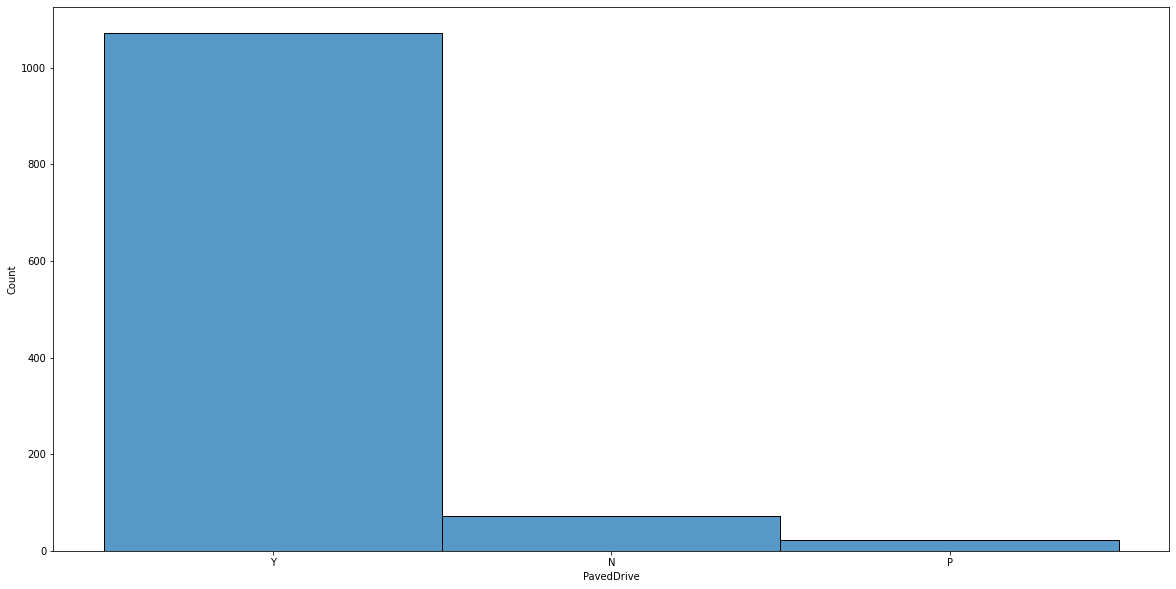

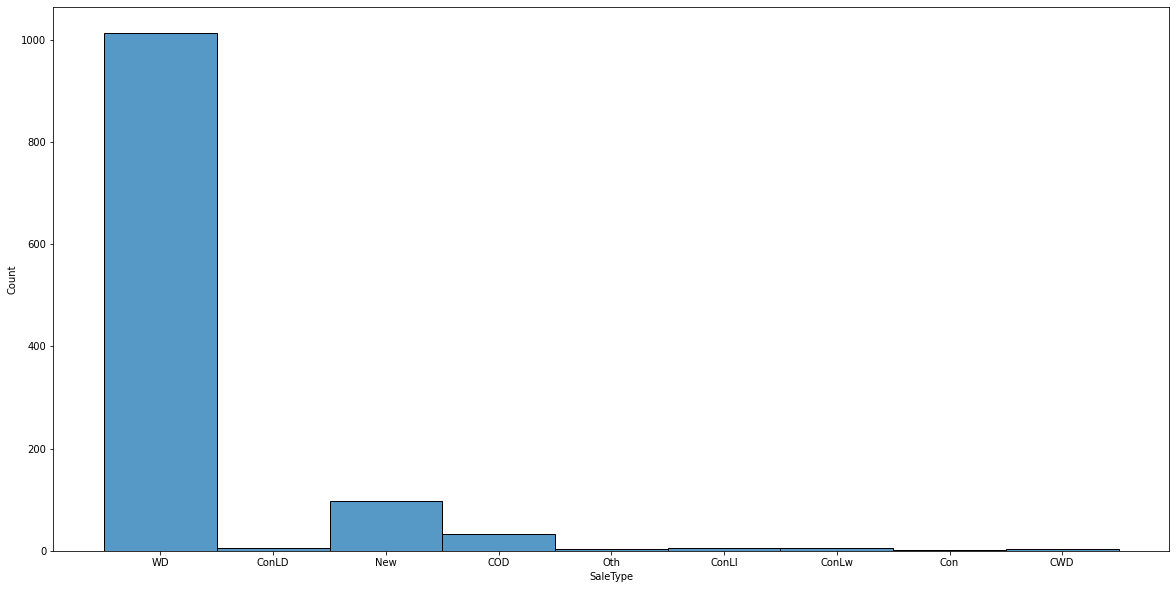

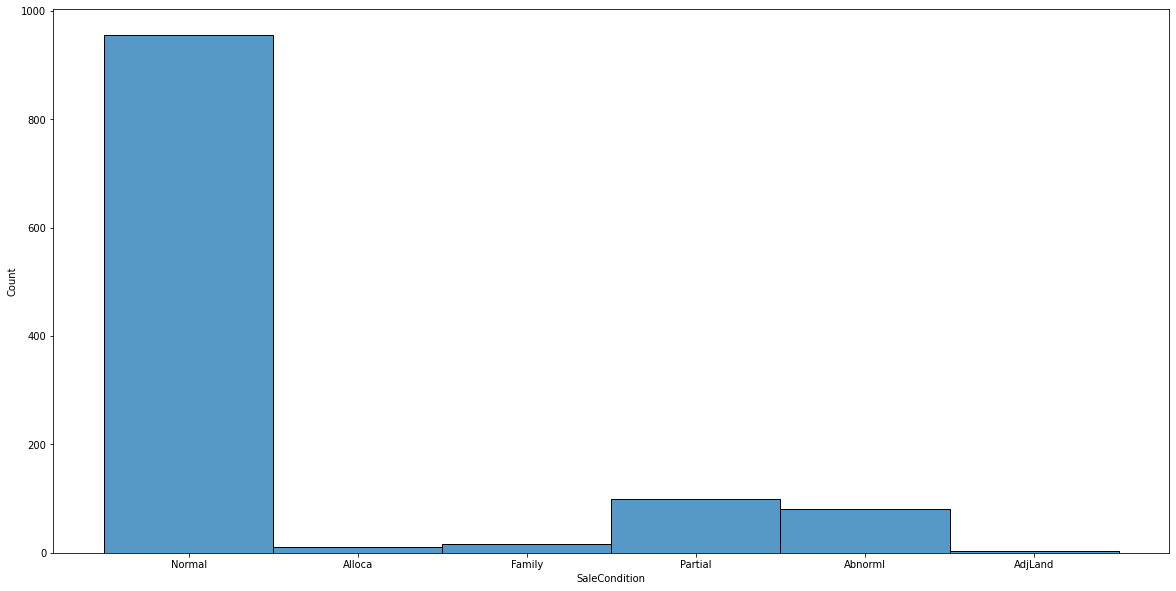

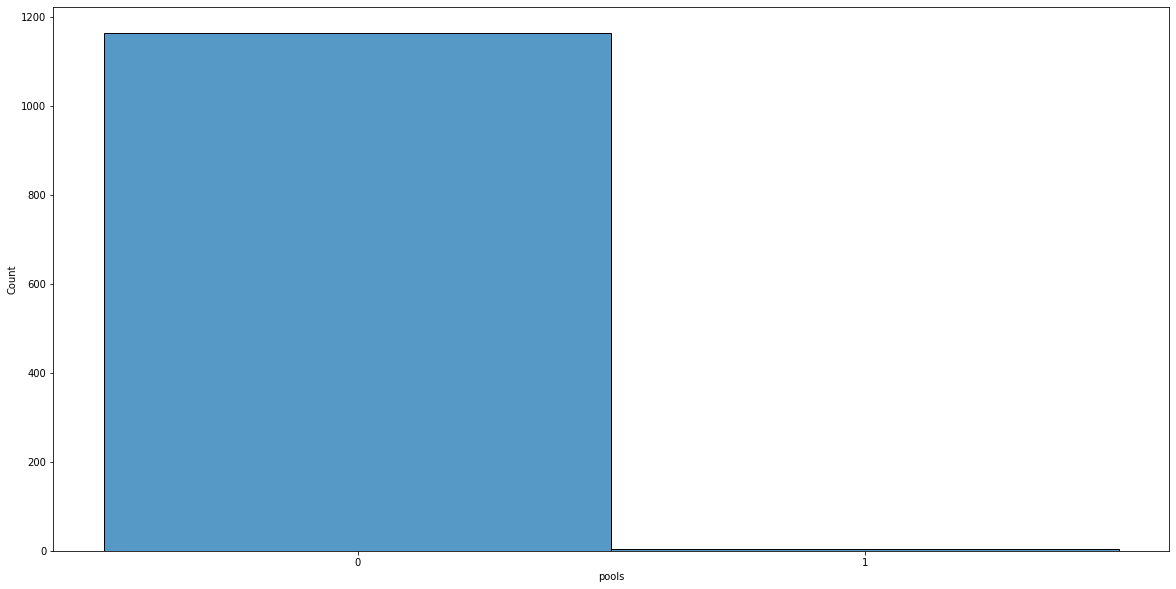

In [37]:
bar_plotter(Pipeline(cat_pipeline_dict.items()).fit_transform(df_train), y_col)

/tmp/ipykernel_4208/327165790.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=(20, 10))


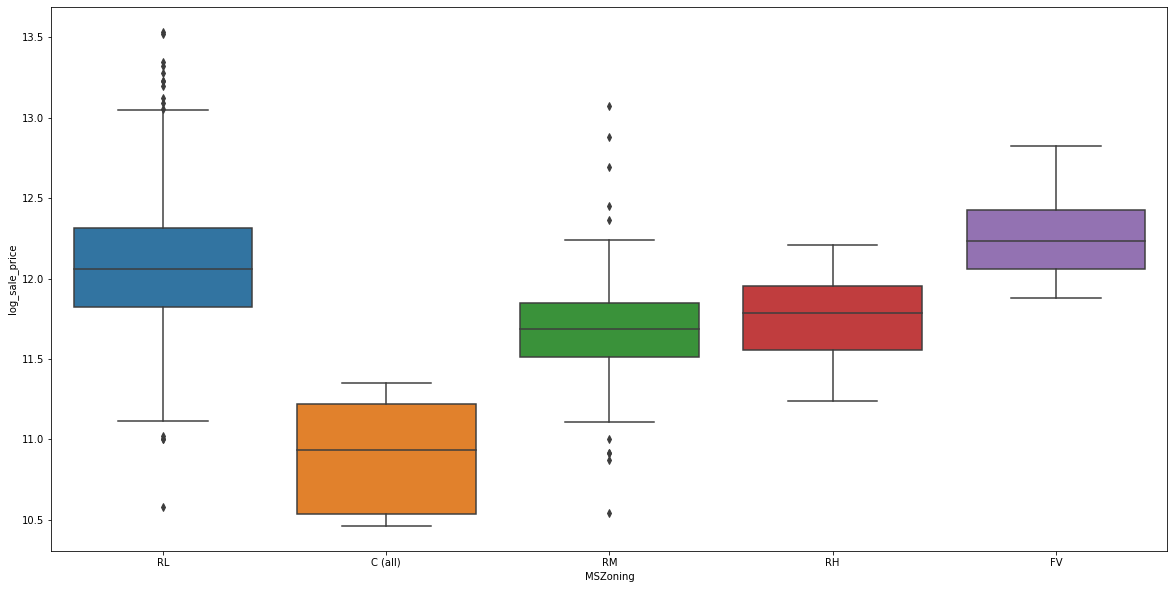

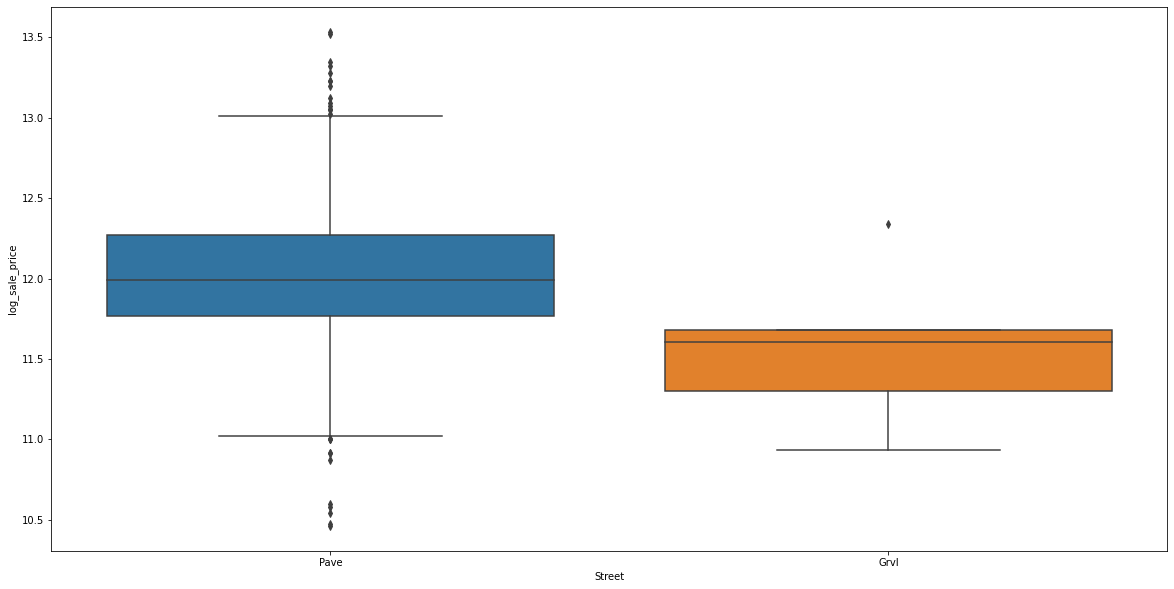

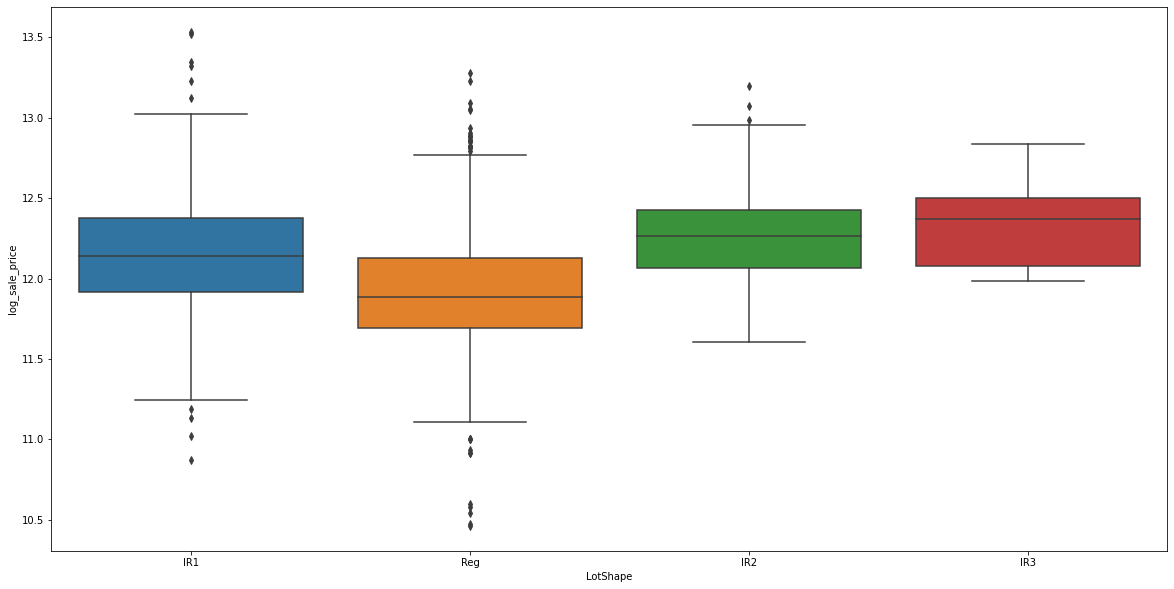

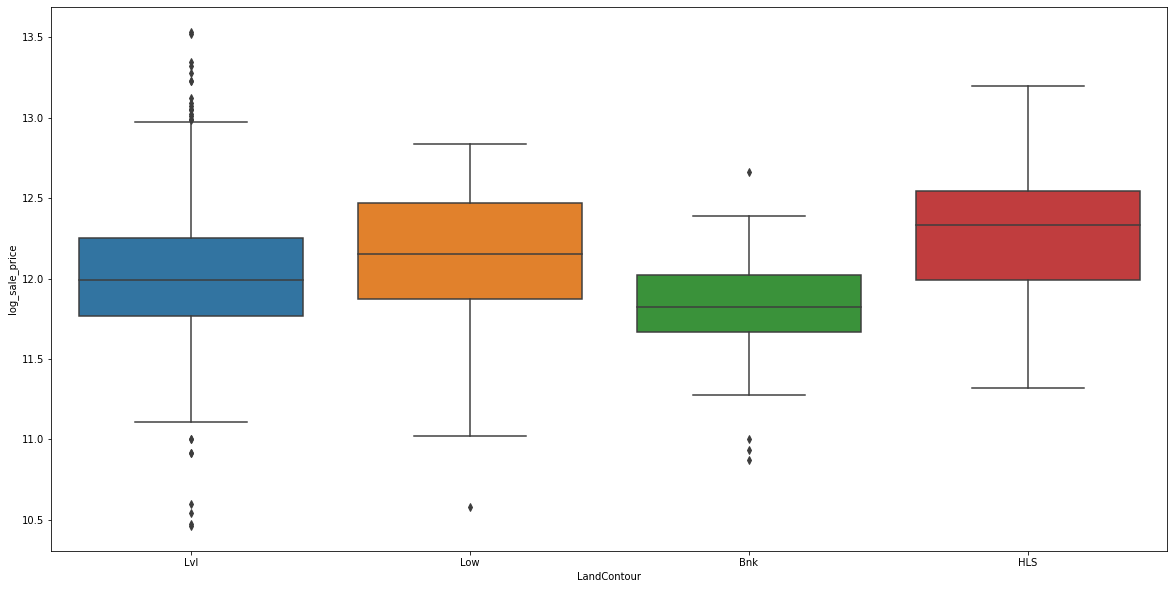

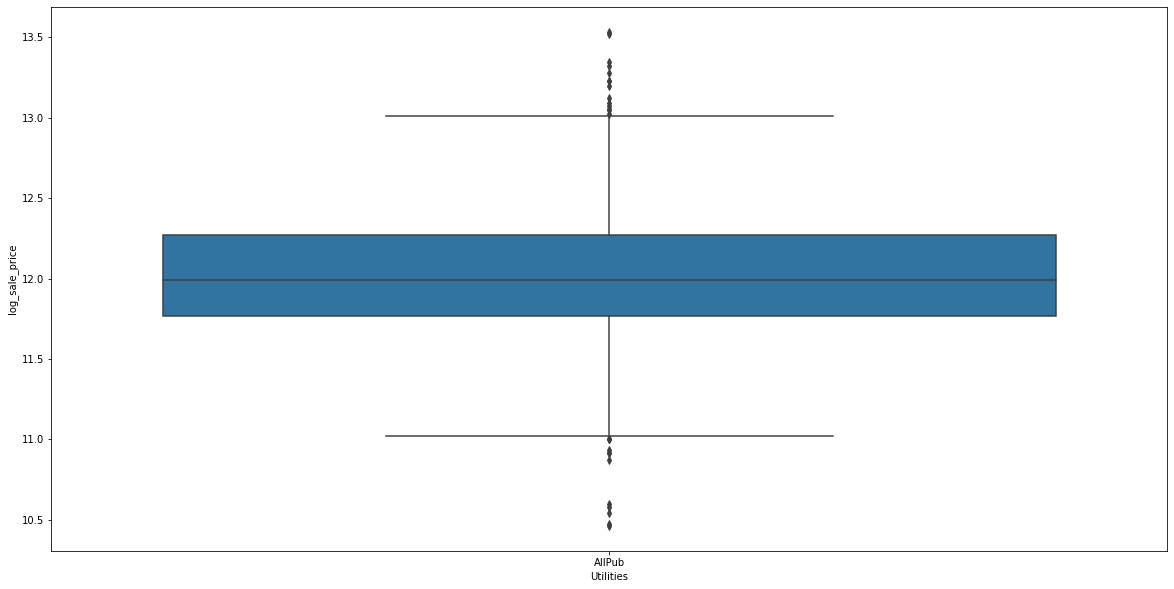

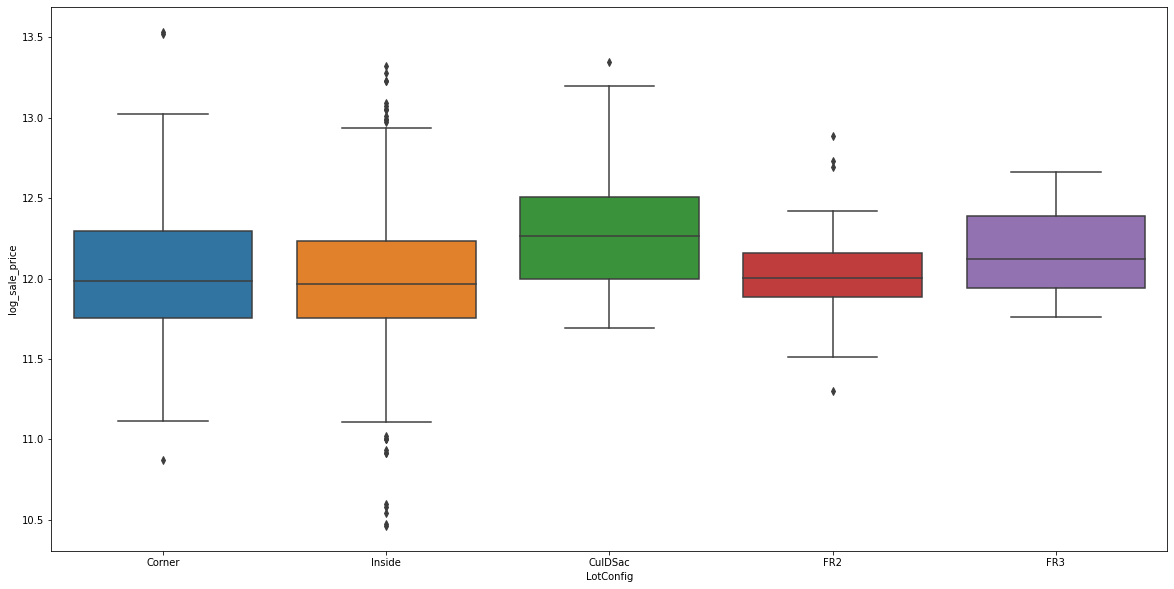

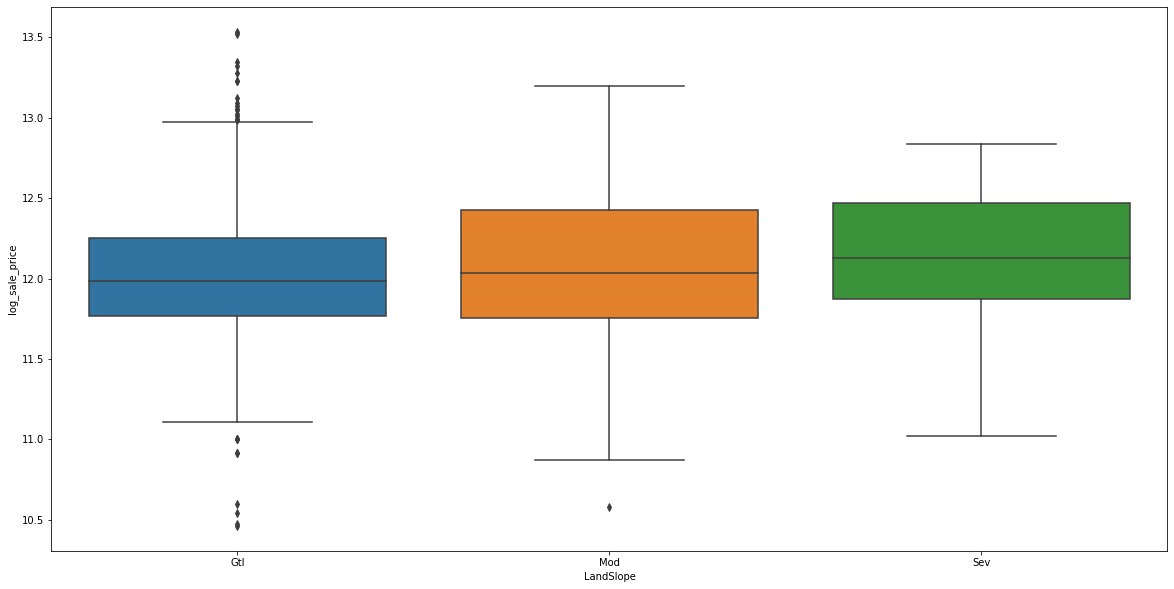

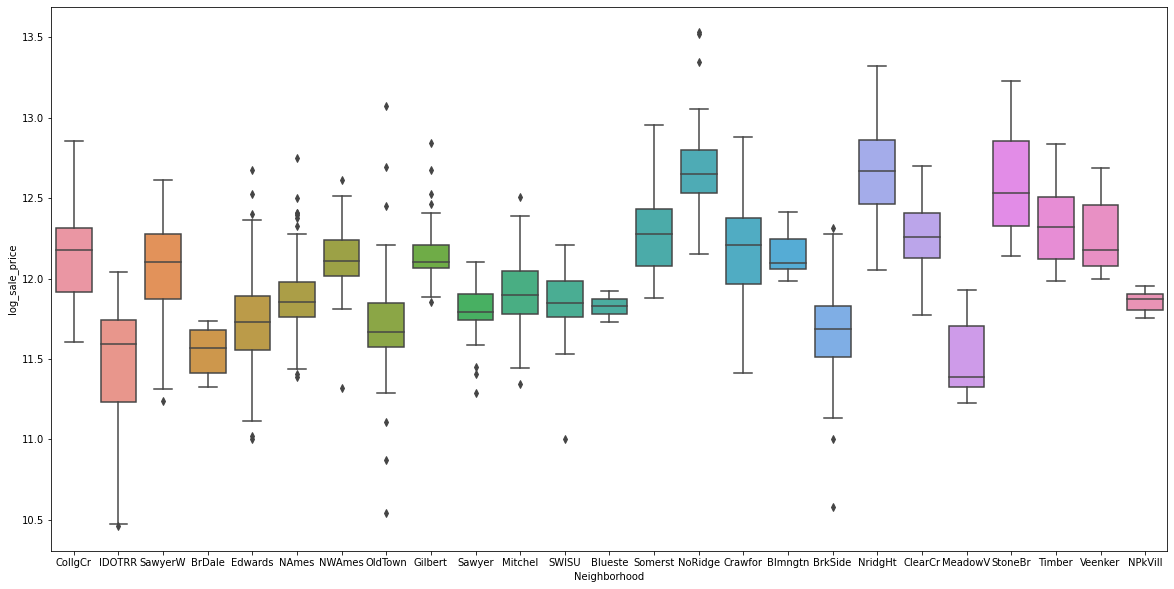

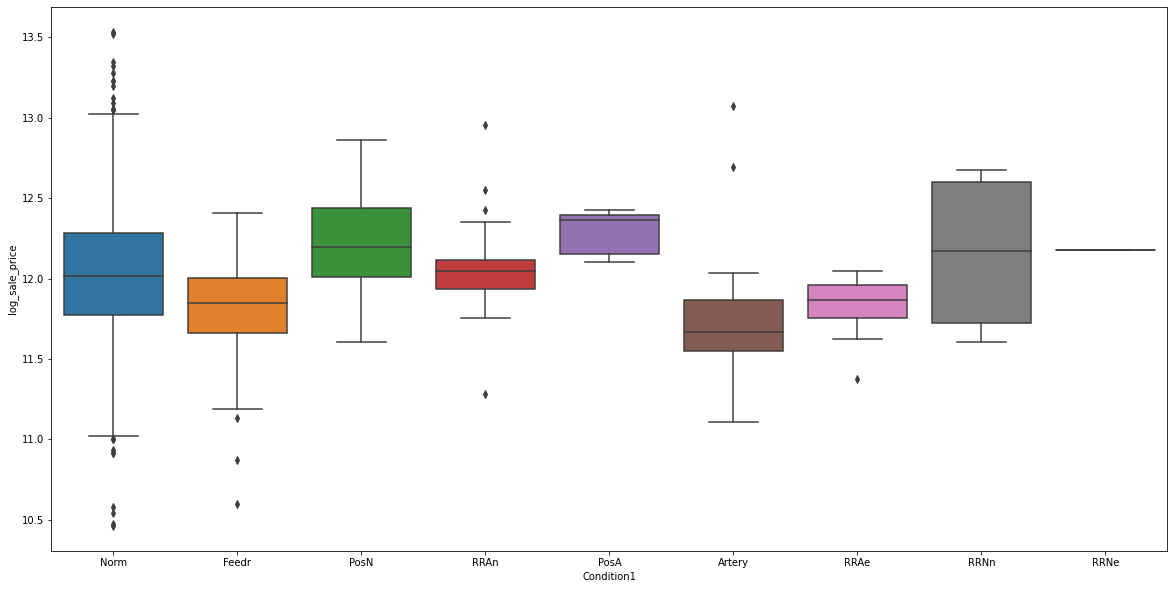

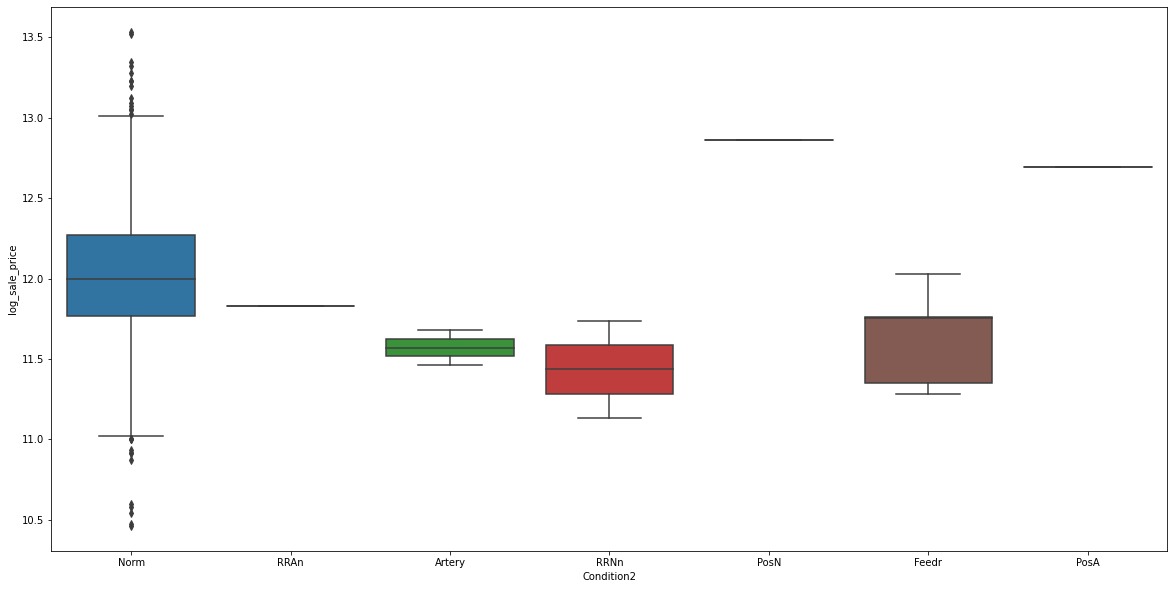

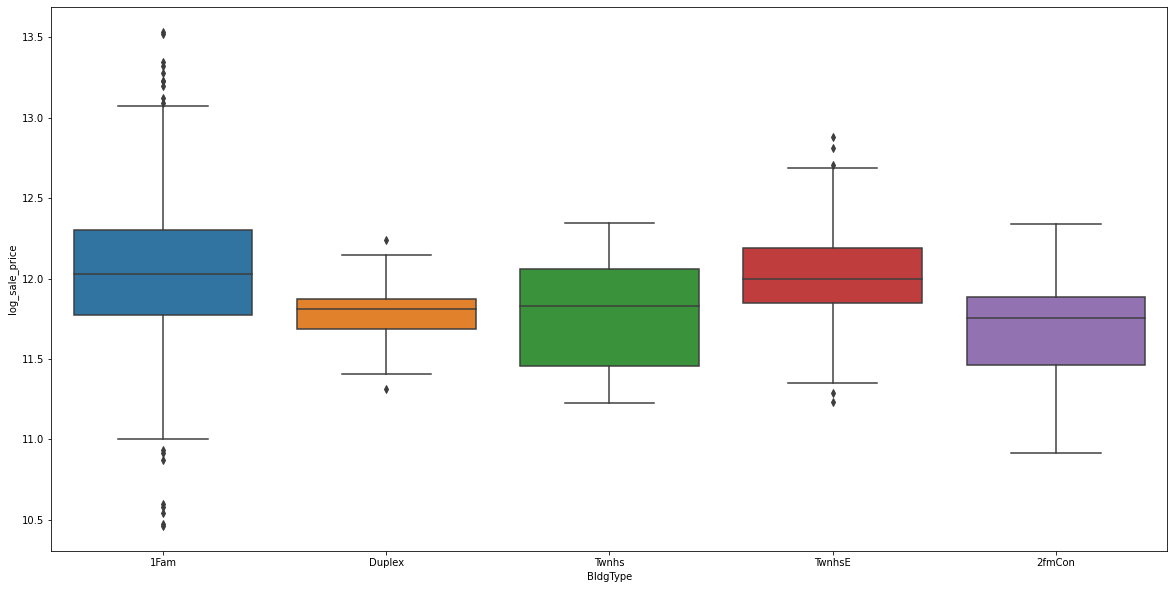

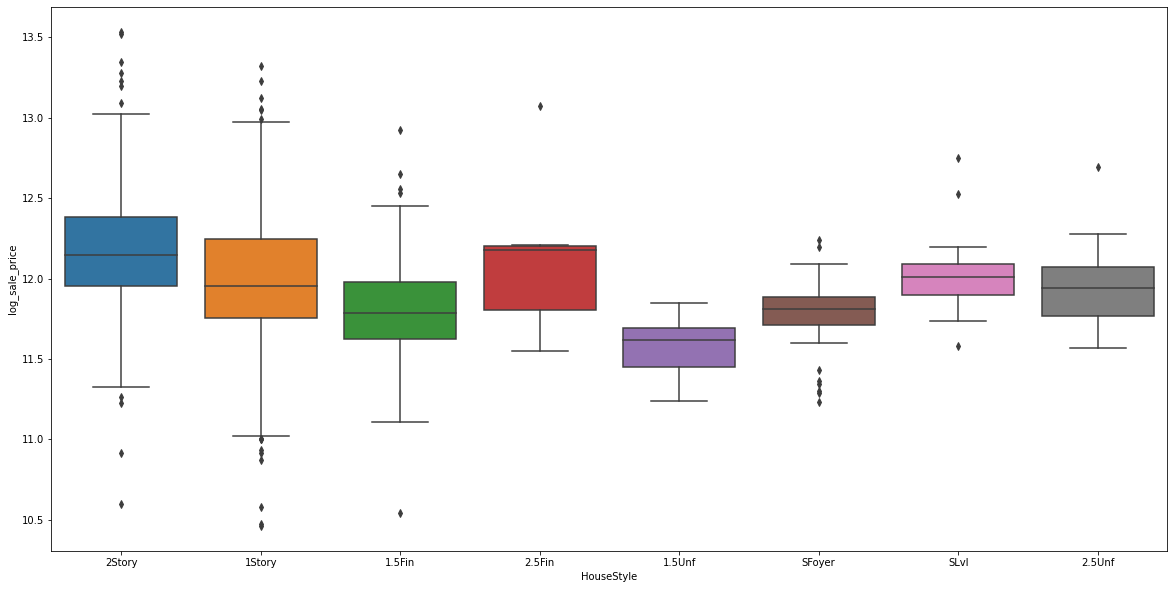

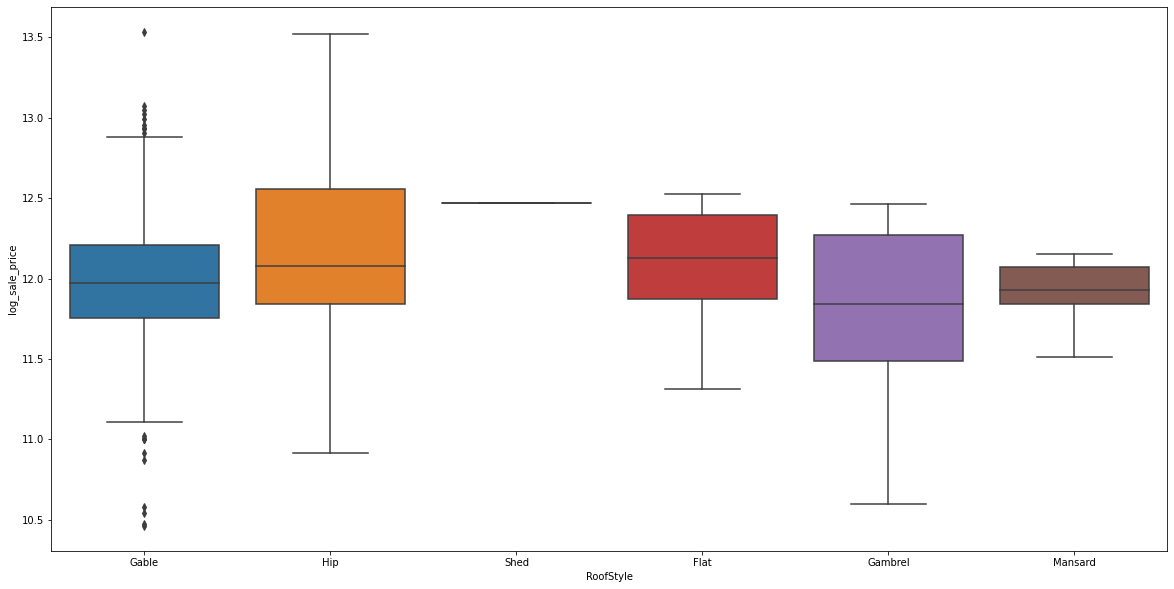

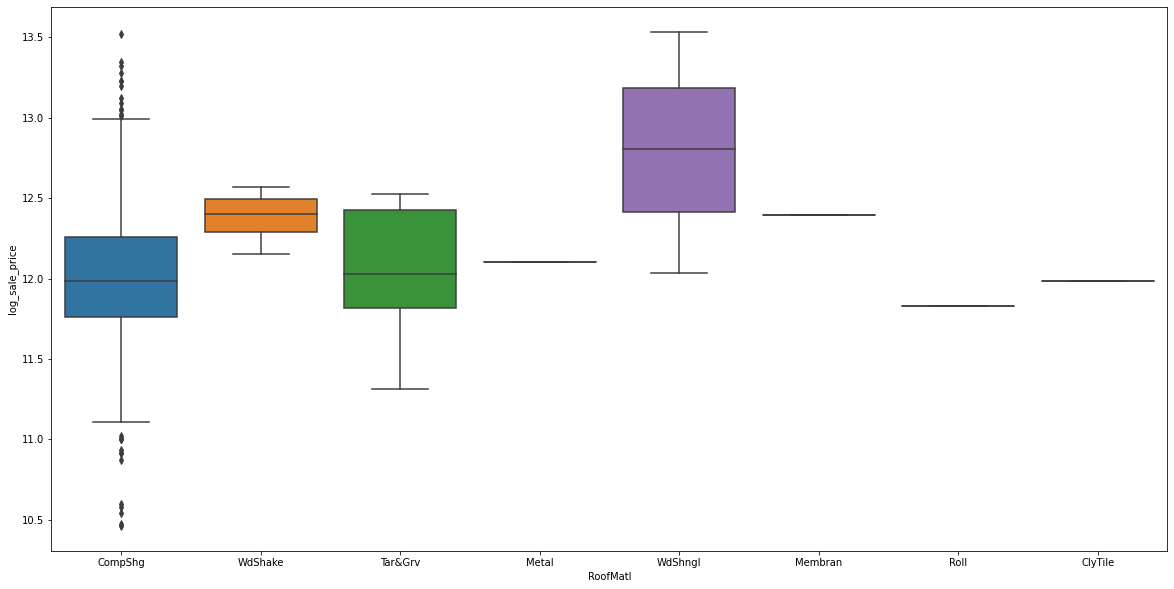

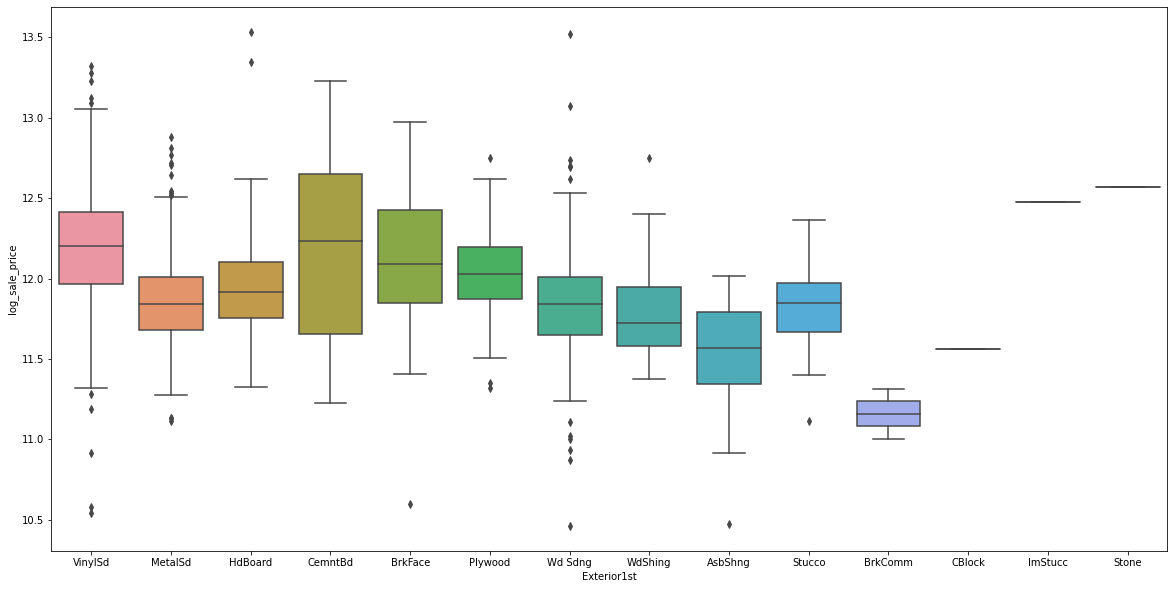

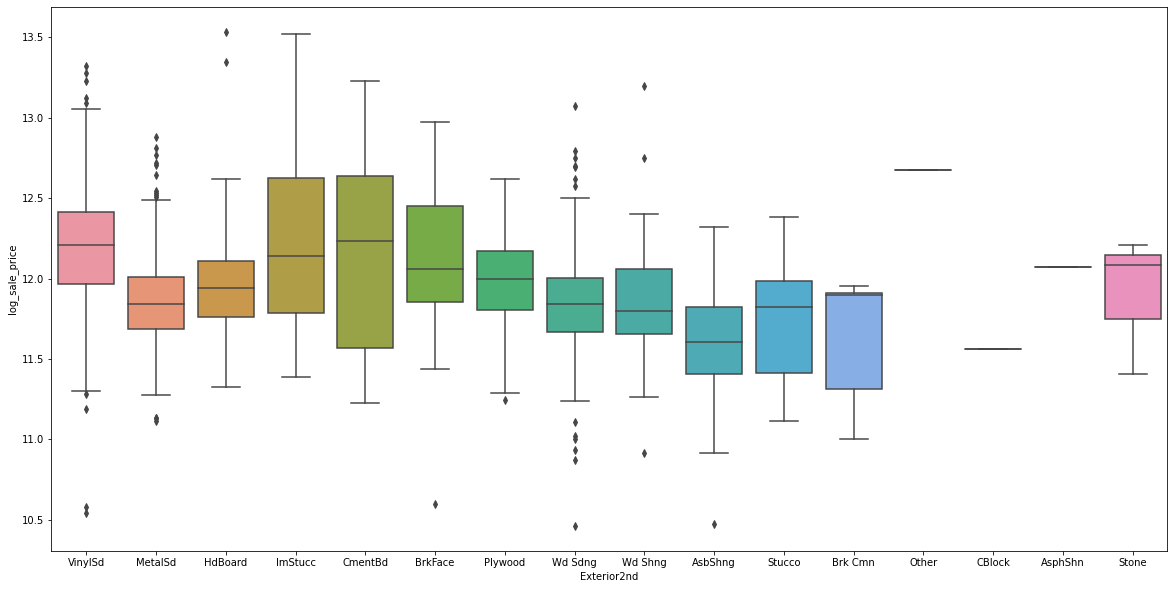

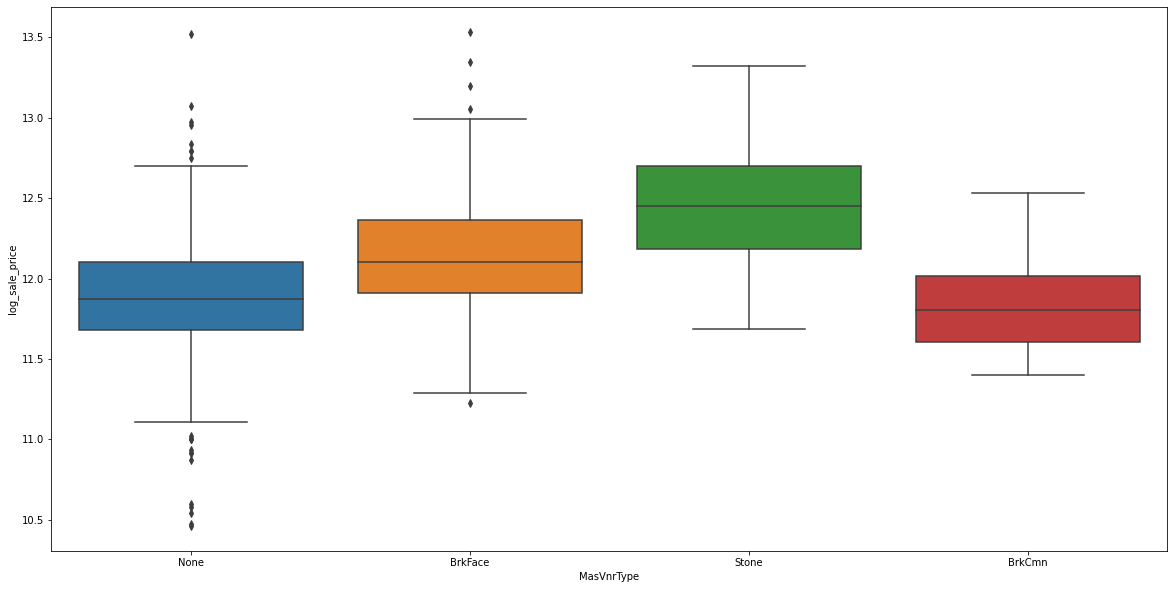

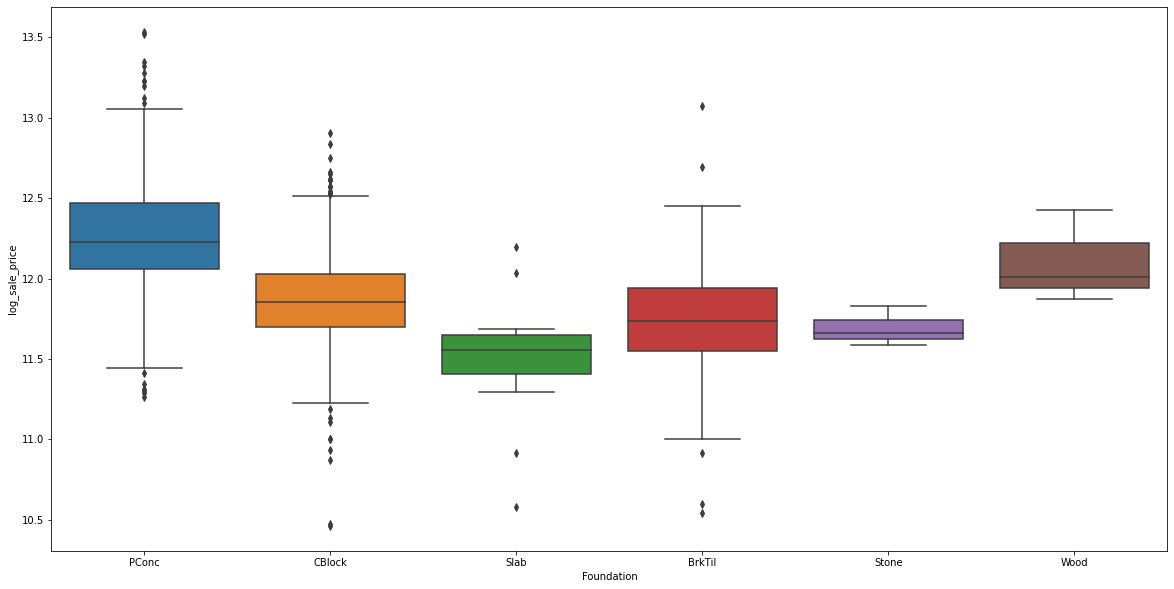

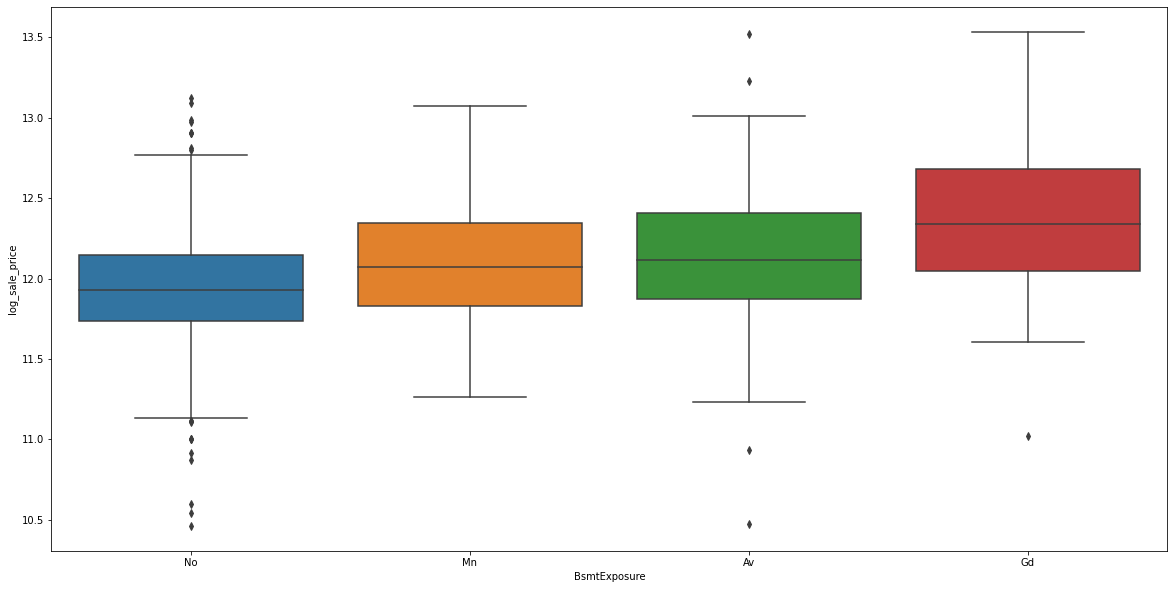

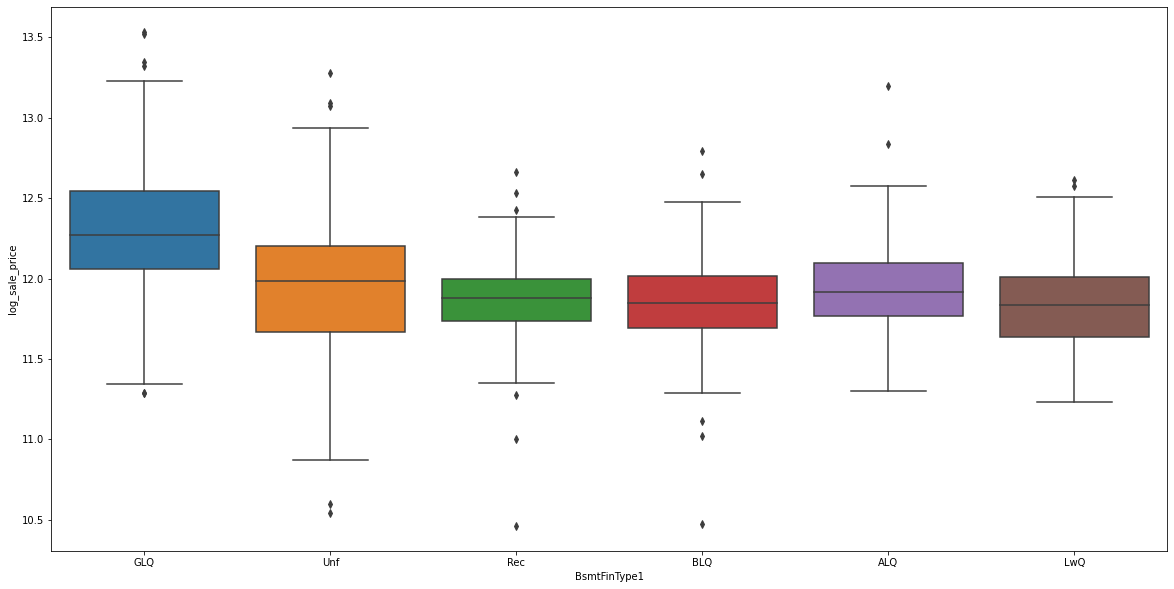

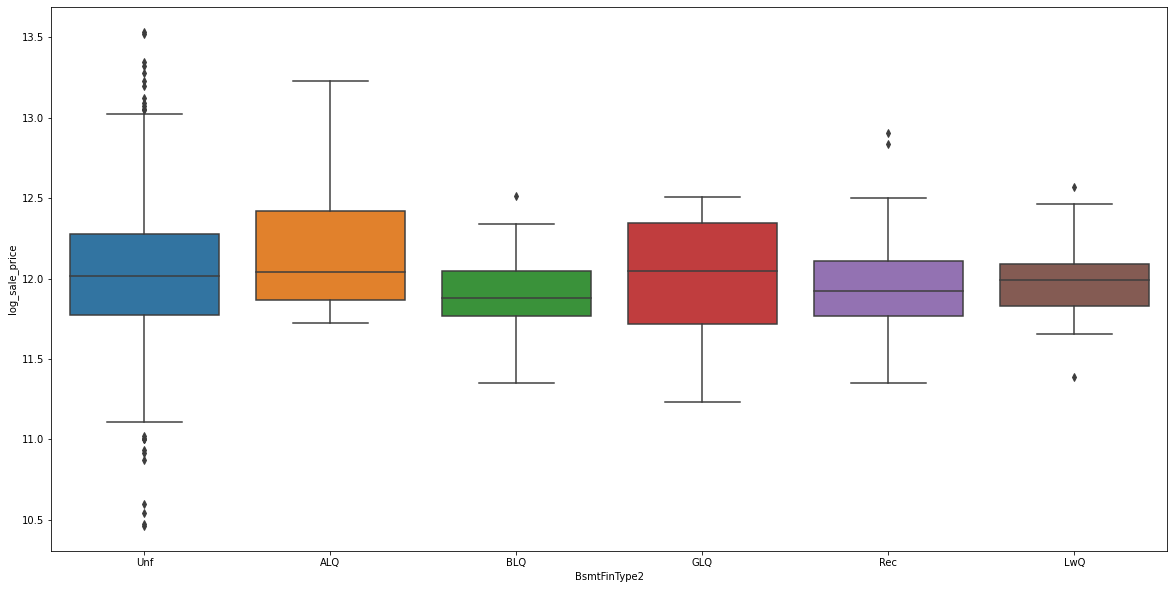

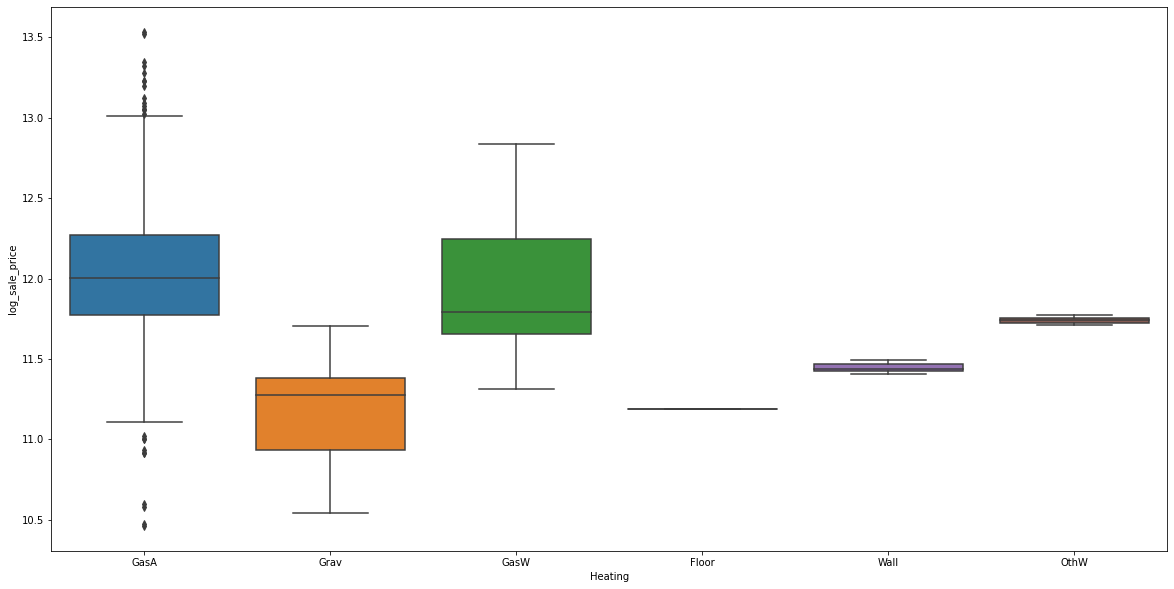

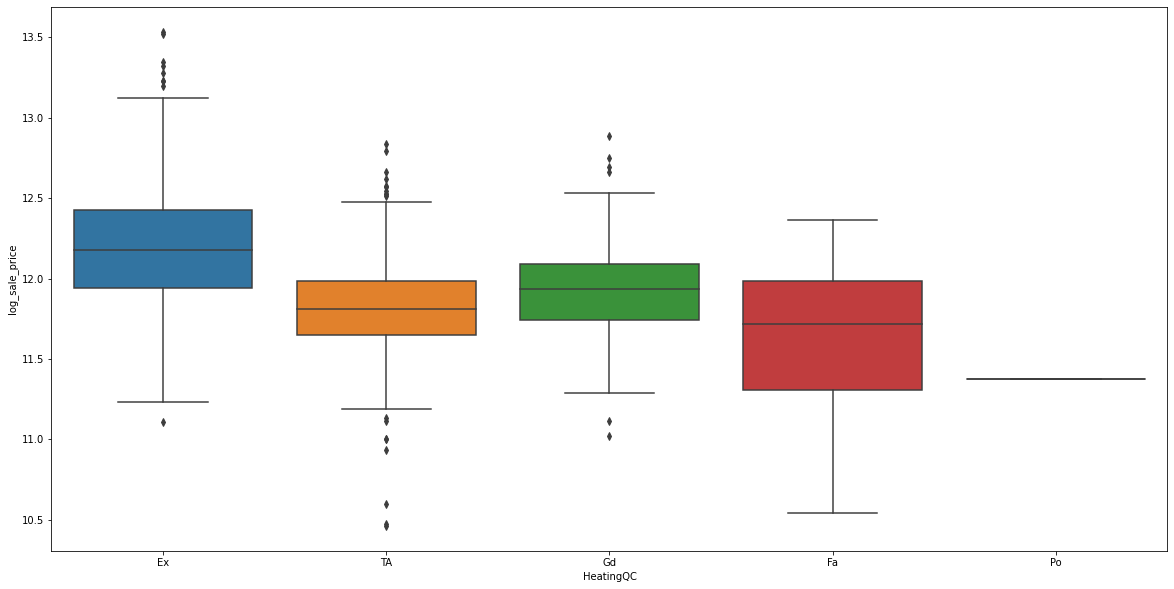

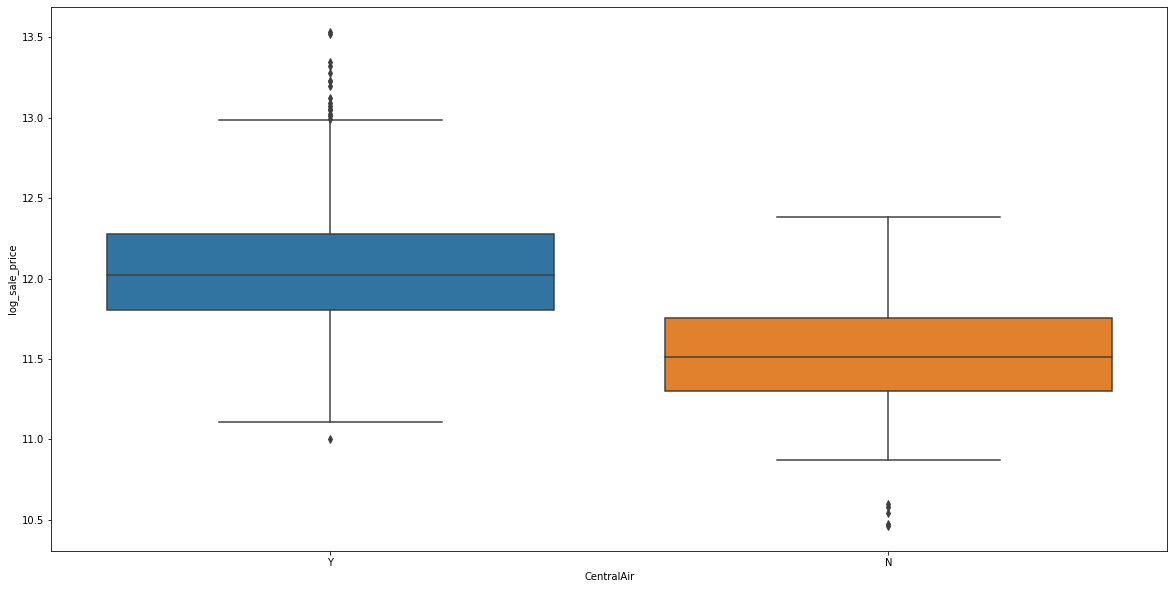

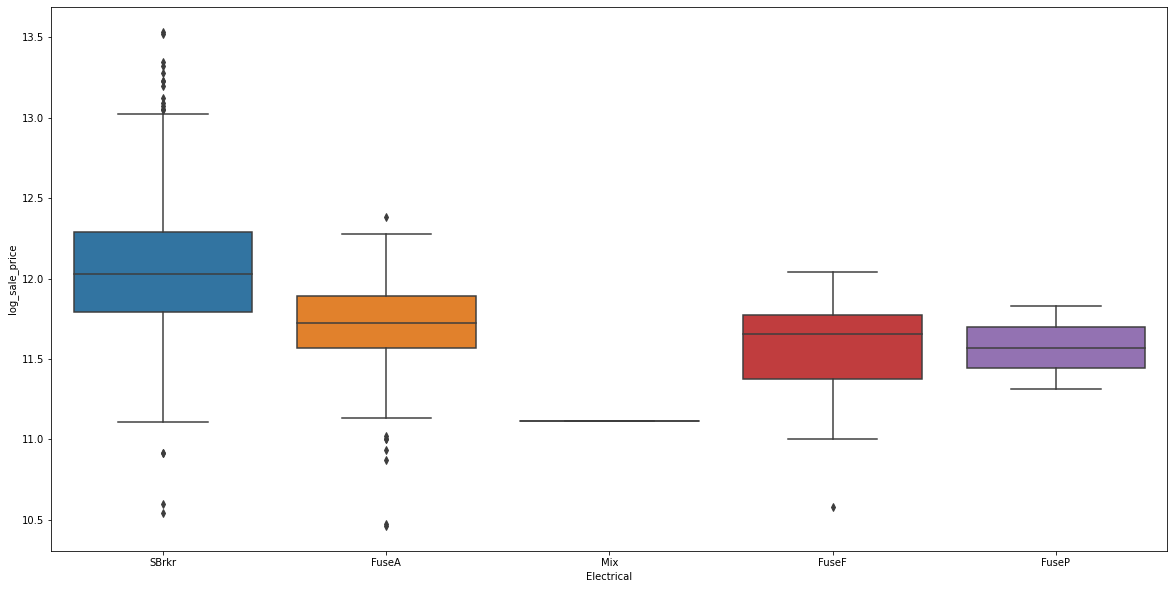

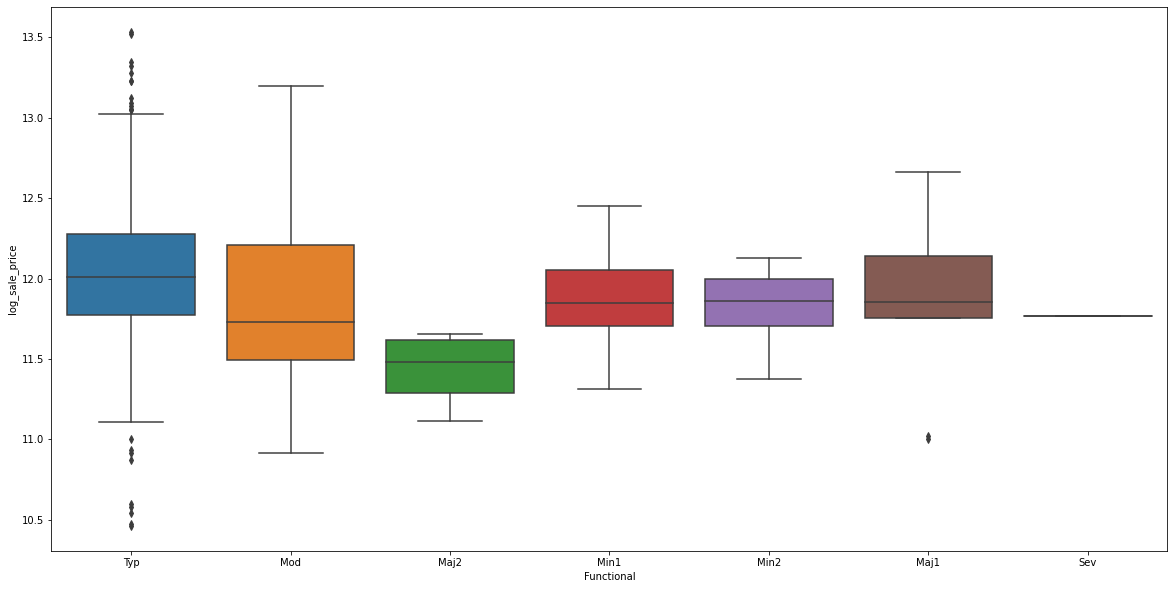

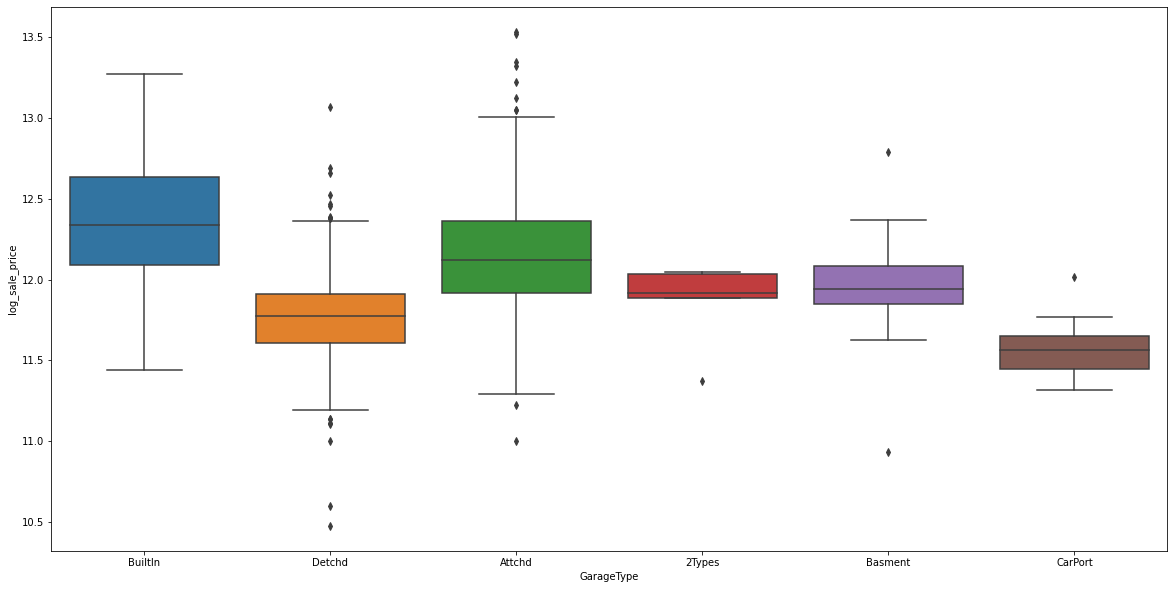

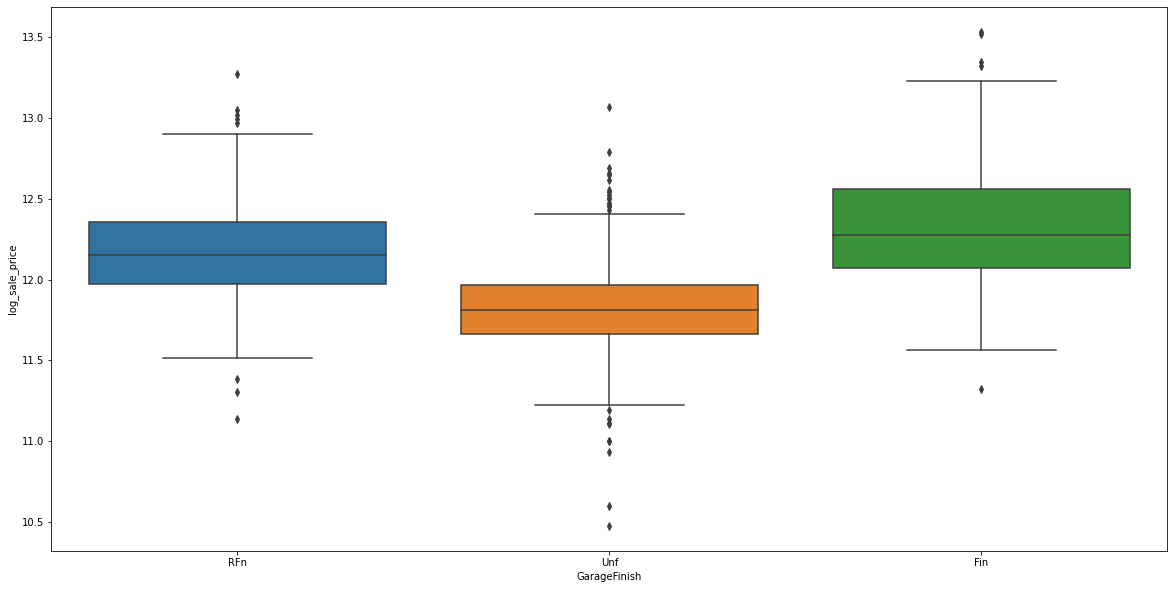

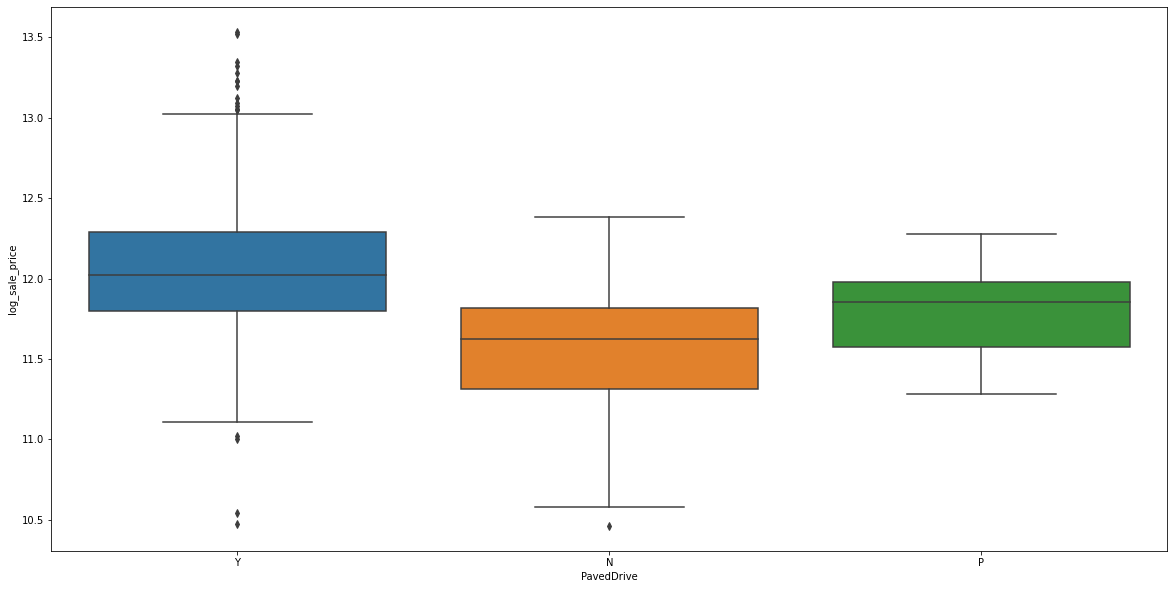

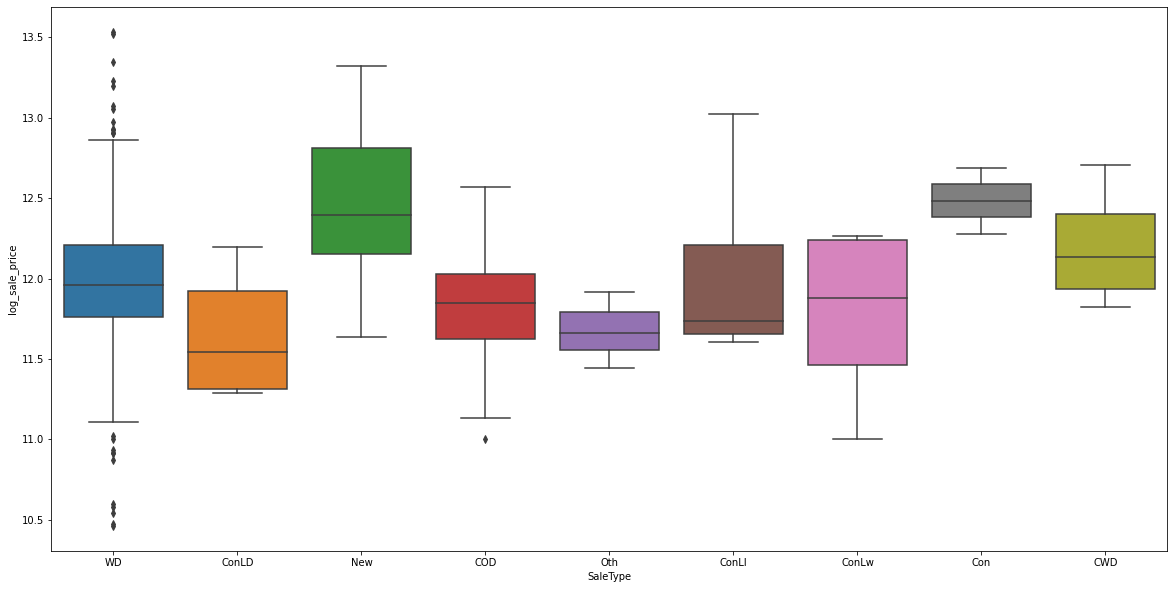

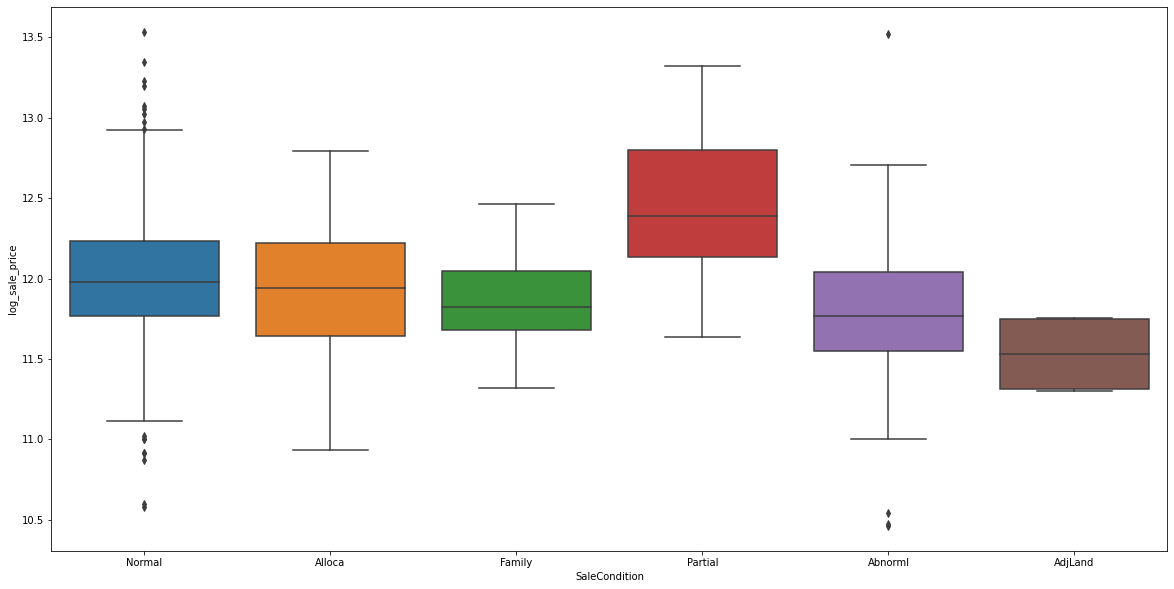

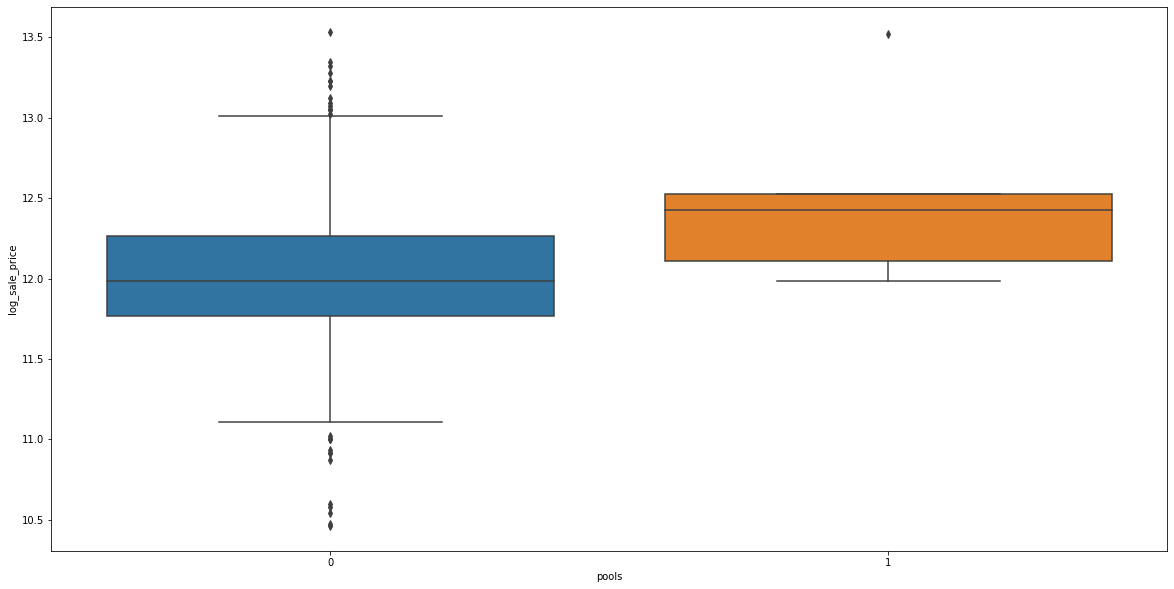

In [38]:
box_plotter(Pipeline(cat_pipeline_dict.items()).fit_transform(df_train), y_col, max_box=-1)

* LotShape join Irregular vc Regular
* Explore Neighborhood (get geoloc data?)
* HouseStyle group (1, 1.5, 2.5Unf / 2, 2.5Fin / other)
* MasVnrType group (None,Cement / BrkFace,Stone)

In [39]:
selected_cat_cols = ["lot_shape"]
class LotShapeGroup(BaseEstimator, TransformerMixin):
    def fit(self, df):
        return self
    def transform(self, df):
        df_out = df.copy()
        df_out["lot_shape"] = "irregular"
        df_out["lot_shape"] = df_out["lot_shape"].mask(df_out["LotShape"]=="Reg", "regular")
        return df_out.drop(columns=["LotShape"])
cat_pipeline_dict["lot_shape_group"] = LotShapeGroup()

In [40]:
class HouseStyleGroup(BaseEstimator, TransformerMixin):
    def fit(self, df):
        return self
    def transform(self, df):
        def groups(val):
            if val in ("1Story", "1.5Fin", "1.5Unf", "2.5Unf"):
                return "1"
            elif val in ("2Story", "2.5Fin"):
                return "2"
            return "other"
        df_out = df.copy()
        df_out["house_style"] = df_out["HouseStyle"].map(groups)
        return df_out.drop(columns=["HouseStyle"])
selected_cat_cols.append("house_style")
cat_pipeline_dict["house_style_group"] = HouseStyleGroup()

In [41]:
class MasVnrTypeGroup(BaseEstimator, TransformerMixin):
    def fit(self, df):
        return self
    def transform(self, df):
        def groups(val):
            if val in ("None", "BrkCmn"):
                return "1"
            return "0"
        df_out = df.copy()
        df_out["mas_vnr_type"] = df_out["MasVnrType"].map(groups)
        return df_out.drop(columns=["MasVnrType"])
selected_cat_cols.append("mas_vnr_type")
cat_pipeline_dict["mas_vnr_type_group"] = MasVnrTypeGroup()

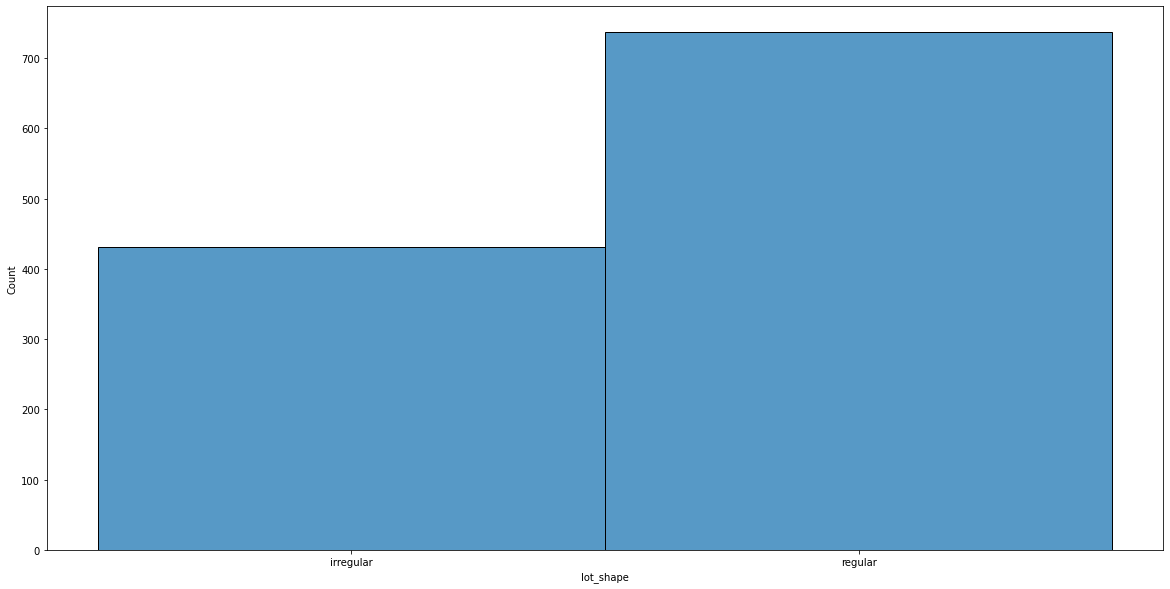

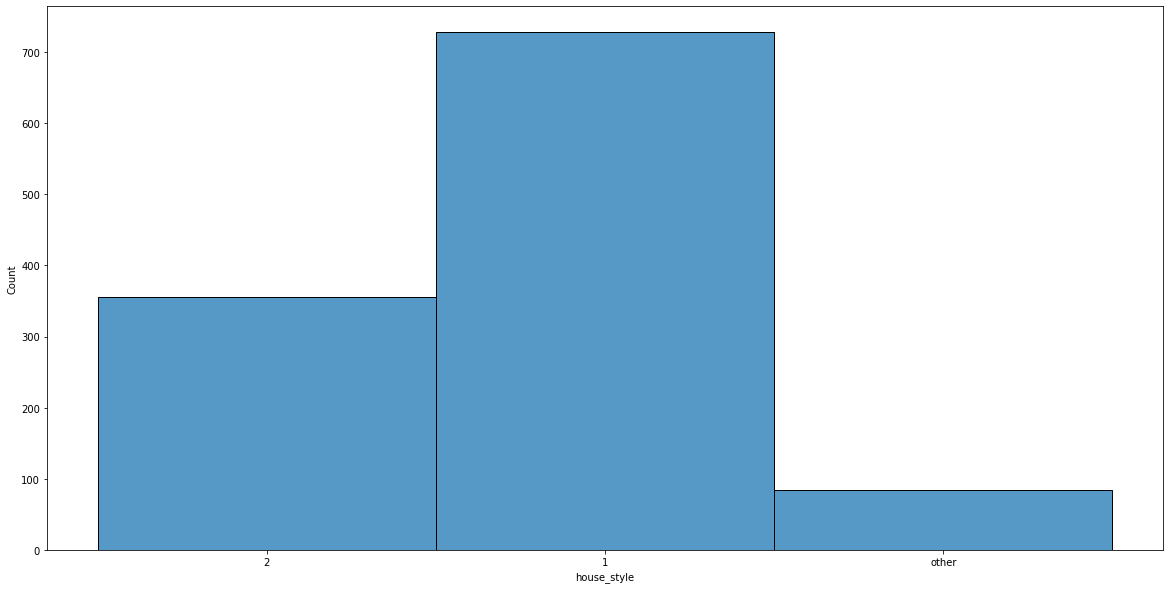

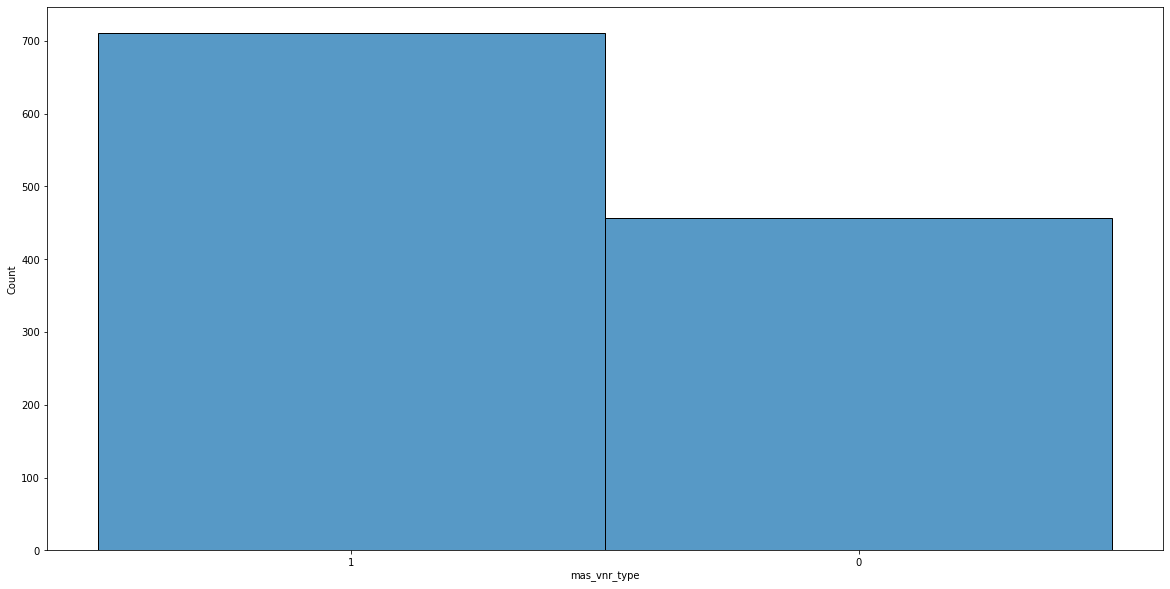

In [42]:
bar_plotter(Pipeline(cat_pipeline_dict.items()).fit_transform(df_train)[selected_cat_cols + [y_col]], y_col)

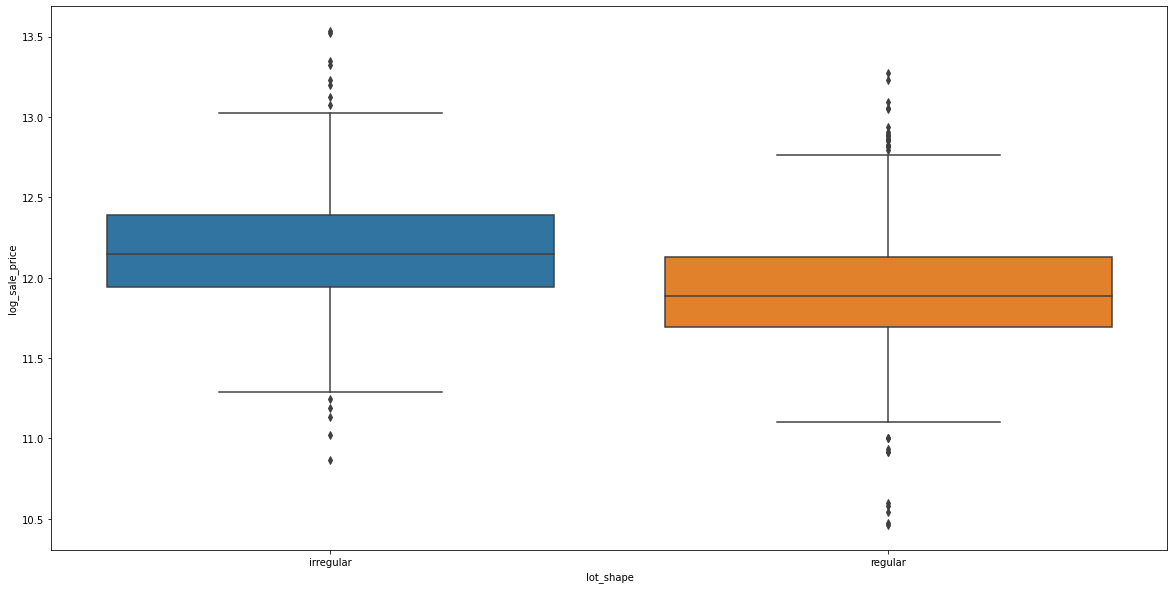

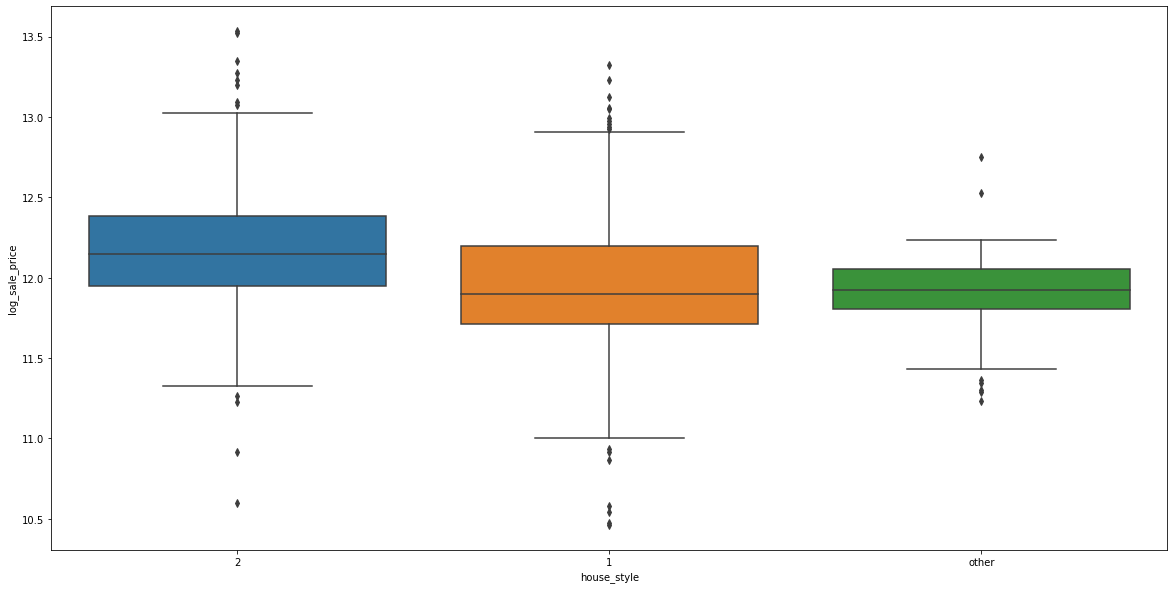

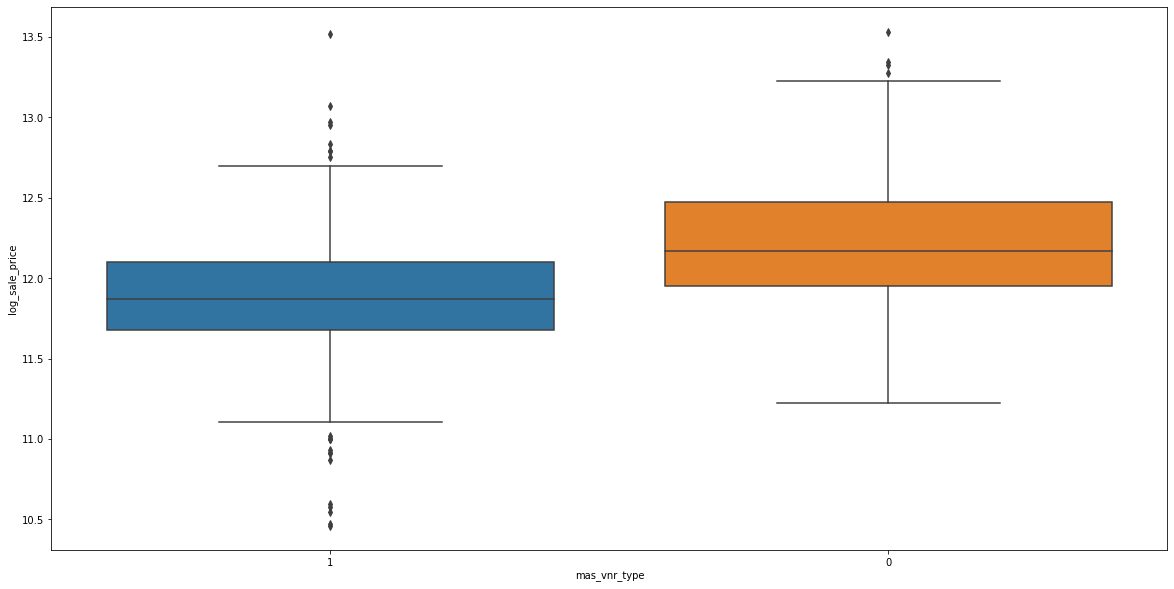

In [43]:
box_plotter(Pipeline(cat_pipeline_dict.items()).fit_transform(df_train)[selected_cat_cols + [y_col]], y_col)

In [44]:
class CatColSelector(BaseEstimator, TransformerMixin):
    def __init__(self, sel_cols=[]):
        self.sel_cols = sel_cols
    def fit(self, df):
        return self
    def transform(self, df):
        return df[self.sel_cols]
cat_pipeline_dict["cat_col_selector"] = CatColSelector(selected_cat_cols)

In [45]:
cat_pipeline_dict["encoder"] = OneHotEncoder(drop="if_binary")

# Build pipelines

In [46]:
num_pipeline = Pipeline(num_pipeline_dict.items())
cat_pipeline = Pipeline(cat_pipeline_dict.items())

full_pipeline = ColumnTransformer([
    ("num", Pipeline(list(num_pipeline_dict.items())), df_train.columns),
    ("cat", Pipeline(list(cat_pipeline_dict.items())), df_train.columns),
])

# Train Elastic Net

In [47]:
import tempfile
import joblib
from pathlib import Path
mlflow.sklearn.autolog()

In [48]:
def run_experiment_grid_search(pipeline, df_train, df_test, model, param_grid, y_col, run_name):
  with mlflow.start_run(run_name=run_name):    
    df_treated = pipeline.fit_transform(df_train)

    grid_search = GridSearchCV(model, param_grid, cv=10, scoring="neg_root_mean_squared_error")
    grid_search.fit(df_treated, df_train[y_col])

    mlflow.log_param("param_grid", param_grid)
    mlflow.log_param("best_params", grid_search.best_params_)

    mlflow.log_metric("train_score", grid_search.best_score_)
    mlflow.log_metric("test_score",
                      grid_search.score(pipeline.transform(df_test), df_test[y_col]))

    mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

    df_submission = pd.read_csv("nobk_data/test.csv")
    df_submission["SalePrice"] = None # just to not throw exception
    df_submission["log_sale_price"] = None # just to not throw exception
    df_sub_treated = pipeline.transform(df_submission)
    df_submission[y_col] = grid_search.predict(df_sub_treated)
    df_submission["SalePrice"] = np.exp(df_submission[y_col])

    with tempfile.TemporaryDirectory() as dp:
      joblib.dump(pipeline, Path(dp, "pipeline.pkl"))
      df_submission[["Id", "SalePrice"]].to_csv(Path(dp, f"{run_name}_out.csv"), index=False)
      mlflow.log_artifacts(dp)

In [91]:
from sklearn.linear_model import ElasticNet
param_grid = {
        "alpha": np.concatenate((np.arange(.01, .1, .01), np.arange(.1, .5, .1))),
        "l1_ratio": np.concatenate((np.arange(.01, .1, .01), np.arange(.1, .5, .1)))
}
model = ElasticNet()
mlflow.set_experiment("ElasticNet")
run_experiment_grid_search(full_pipeline, df_train, df_test, model, param_grid, y_col, "elasticNet-full_pipeline")
run_experiment_grid_search(num_pipeline, df_train, df_test, model, param_grid, y_col, "elasticNet-num_pipeline")

# Train Random Forest

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error


def run_experiment_random_forest(df_train, df_test, y_col, pipeline, run_name):
  with mlflow.start_run(run_name=run_name):
    df_treated = pipeline.fit_transform(df_train)
    last_val_score = -1
    sel_md = 1
    for md in range(5, 20):
      rfr = RandomForestRegressor(max_depth=md)
      history = cross_validate(rfr, df_treated, df_train[y_col],
                                cv=10, scoring="neg_root_mean_squared_error",
                                return_train_score=True)
      val_score = np.mean(history["test_score"])
      if val_score > last_val_score:
        last_val_score = val_score
        sel_md = md
      elif abs(last_val_score - val_score) >= 0.0001:
        # select elbow
        last_val_score = 0

      mlflow.log_metric("train_score", np.mean(history["train_score"]), step=md)
      mlflow.log_metric("val_score", val_score, step=md)

    mlflow.log_param("selected_max_depth", sel_md)
    rfr = RandomForestRegressor(max_depth=sel_md)
    rfr.fit(df_treated, df_train[y_col])
    
    y_pred = rfr.predict(pipeline.transform(df_test))
    mlflow.log_metric("test_score",
                      -(mean_squared_error(df_test[y_col], y_pred)**.5))

    mlflow.sklearn.log_model(rfr, "model")

    df_submission = pd.read_csv("nobk_data/test.csv")
    df_submission["SalePrice"] = None # just to not throw exception
    df_submission["log_sale_price"] = None # just to not throw exception
    df_sub_treated = pipeline.transform(df_submission)
    df_submission[y_col] = rfr.predict(df_sub_treated)
    df_submission["SalePrice"] = np.exp(df_submission[y_col])

    with tempfile.TemporaryDirectory() as dp:
      joblib.dump(pipeline, Path(dp, "pipeline.pkl"))
      df_submission[["Id", "SalePrice"]].to_csv(Path(dp, f"{run_name}_out.csv"), index=False)
      mlflow.log_artifacts(dp)
    

In [ ]:
mlflow.set_experiment("RandomForest")
run_experiment_random_forest(df_train, df_test, y_col, full_pipeline, "RandomForest-full_pipeline")
run_experiment_random_forest(df_train, df_test, y_col, num_pipeline, "RandomForest-num_pipeline")

# Train XGBoost

In [58]:
param_grid = {"booster": ["gblinear"], "reg_lambda": np.concatenate((np.arange(.01, .1, .01), np.arange(.1, .5, .1))), "reg_alpha": np.arange(.1, 1, .1)}
model = xgb.sklearn.XGBRegressor()
mlflow.set_experiment("XGBoost")
run_experiment_grid_search(model=model, y_col=y_col,
  pipeline=full_pipeline, df_train=df_train, df_test=df_test, param_grid=param_grid, run_name="XGBRegLinear-full_pipeline")

2022/07/12 14:25:59 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('drop_sale_price', DropSalePrice()), ('qual_ind_transformer', QualityIndTransformer()), ('rooms_baths_adder', RoomsBathsAdder()), ('correlated_col_dropper', CorrelatedColumDropper(cols=['rooms', 'GarageArea', 'GarageYrBlt'])), ('quality_adder', ...`
2022/07/12 14:25:59 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/07/12 14:25:59 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/07/12 14:26:02 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('cat_col_dropper', CatColDropper(drop_cols=['Alley', 'Fence', 'MiscFeature'])), ('pool_encoder', PoolsEncoder()), ('lot_shape_gr

In [59]:
def run_experiment_xbtree(df_train, df_test, y_col, pipeline, run_name):
  with mlflow.start_run(run_name=run_name):
    df_treated = pipeline.fit_transform(df_train)
    last_val_score = -1
    sel_md = 1
    for md in range(5, 20):
      rfr = xgb.sklearn.XGBRegressor(booster="gbtree", max_depth=md)
      history = cross_validate(rfr, df_treated, df_train[y_col],
                                cv=10, scoring="neg_root_mean_squared_error",
                                return_train_score=True)
      val_score = np.mean(history["test_score"])
      if val_score > last_val_score:
        last_val_score = val_score
        sel_md = md
      elif abs(last_val_score - val_score) >= 0.0001:
        # select elbow
        last_val_score = 0

      mlflow.log_metric("train_score", np.mean(history["train_score"]), step=md)
      mlflow.log_metric("val_score", val_score, step=md)

    mlflow.log_param("selected_max_depth", sel_md)
    rfr = xgb.sklearn.XGBRegressor(booster="gbtree", max_depth=sel_md)
    rfr.fit(df_treated, df_train[y_col])
    
    y_pred = rfr.predict(pipeline.transform(df_test))
    mlflow.log_metric("test_score",
                      -(mean_squared_error(df_test[y_col], y_pred)**.5))

    mlflow.sklearn.log_model(rfr, "model")

    df_submission = pd.read_csv("nobk_data/test.csv")
    df_submission["SalePrice"] = None # just to not throw exception
    df_submission["log_sale_price"] = None # just to not throw exception
    df_sub_treated = pipeline.transform(df_submission)
    df_submission[y_col] = rfr.predict(df_sub_treated)
    df_submission["SalePrice"] = np.exp(df_submission[y_col])

    with tempfile.TemporaryDirectory() as dp:
      joblib.dump(pipeline, Path(dp, "pipeline.pkl"))
      df_submission[["Id", "SalePrice"]].to_csv(Path(dp, f"{run_name}_out.csv"), index=False)
      mlflow.log_artifacts(dp)

In [60]:
mlflow.set_experiment("XGBoost")
run_experiment_xbtree(df_train, df_test, y_col, full_pipeline, "XGBTree-full_pipeline")

2022/07/12 14:39:22 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('drop_sale_price', DropSalePrice()), ('qual_ind_transformer', QualityIndTransformer()), ('rooms_baths_adder', RoomsBathsAdder()), ('correlated_col_dropper', CorrelatedColumDropper(cols=['rooms', 'GarageArea', 'GarageYrBlt'])), ('quality_adder', ...`
2022/07/12 14:39:22 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/07/12 14:39:22 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/07/12 14:39:25 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('cat_col_dropper', CatColDropper(drop_cols=['Alley', 'Fence', 'MiscFeature'])), ('pool_encoder', PoolsEncoder()), ('lot_shape_gr